In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

# We load the original dataset
df = pd.read_excel('BASE_DATOS.xlsx', engine='openpyxl')
print("Number of variables:", len(df.columns))
print("Number of records:", len(df))


Number of variables: 290
Number of records: 2478


In [136]:
# Function that counts the number of variables and records of a DataFrame

# INPUT:
# df: DataFrame with the data
# OUTPUT:
# n_variables: number of variables of the DataFrame
# n_records: number of records of the DataFrame

def count_variables_records(df):
    n_variables = len(df.columns)
    n_records = len(df)
    print('Number of variables:', n_variables)
    print('Number of records:', n_records)

# Function that removes the columns that exceed a given maximum percentage of null values

# INPUT:
# df: DataFrame with the data
# porcentage: maximum percentage of null values that a column can have
# OUTPUT:
# df: DataFrame with the columns that do not exceed the percentage of null values

def remove_columns_nulls(df, porcentage):
    # We calculate the maximum number of null values that a column can have
    max_nulls = len(df)*porcentage
    # We remove the columns that exceed the maximum number of null values
    df = df.dropna(axis=1, thresh=max_nulls)
    return df

# Function that removes the rows that contain null values in the DataFrame. It also returns the number of records that have been removed

# INPUT:
# df: DataFrame with the data
# OUTPUT:
# df: DataFrame without the rows that contain null values
# n_rows: number of rows that have been removed

# (!)
def remove_rows_nulls(df):
    # We calculate the number of rows that are going to be removed
    n_rows = (df.isnull().sum(axis=1)>0).sum()
    # We remove the rows that contain null values
    df = df.dropna()
    return df, n_rows

# Function that analyzes the correlation between the variables of a DataFrame

# INPUT:
# df: DataFrame with the data
# ignore_vars: list with the variables that are going to be ignored in the analysis. By default it is an empty list
# print_matrix: boolean that indicates if the correlation matrix is shown. By default it is False
# heatmap: boolean that indicates if the heatmap of the correlation matrix is shown. By default it is True
# OUTPUT:
# p_value_matrix: DataFrame with the p-values of the chi-squared test
# discrete_p_matrix: DataFrame with the discretized p-values of the chi-squared test

def analyze_correlations(df, ignore_vars=None, print_matrix=False, heatmap=True):
    # If ignore_vars is not provided, initialize it as an empty list
    if ignore_vars is None:
        ignore_vars = []
    
    # Create a DataFrame to store the p-values
    chi2df = pd.DataFrame(index=df.columns, columns=df.columns)
    
    # Calculate the p-values using chi-squared test
    for col1 in df.columns:
        for col2 in df.columns:
            if col1 in ignore_vars or col2 in ignore_vars:
                chi2df.loc[col1, col2] = None  # Mark as None if variable should be ignored
            elif col1 == col2:
                chi2df.loc[col1, col2] = 0
            else:
                contingency_table = pd.crosstab(df[col1], df[col2])
                chi2, p, dof, expected = chi2_contingency(contingency_table)
                chi2df.loc[col1, col2] = p

    p_value_matrix = chi2df.astype(float)
    
    # Discretize p-values into categories
    def discretize_p_values(p_value):
        if p_value is None:
            return 'X'
        elif p_value == 0:
            return 'X'
        elif p_value < 0.01:
            return '***'
        elif p_value < 0.05:
            return '**'
        elif p_value < 0.1:
            return '*'
        else:
            return 'ns'
    
    discrete_p_matrix = p_value_matrix.applymap(discretize_p_values)

    if print_matrix:
        print(discrete_p_matrix)

    if heatmap:
        # Drop the rows and columns for the ignored variables
        filtered_p_value_matrix = p_value_matrix.drop(ignore_vars, axis=0).drop(ignore_vars, axis=1)
        filtered_discrete_p_matrix = discrete_p_matrix.drop(ignore_vars, axis=0).drop(ignore_vars, axis=1)
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(filtered_p_value_matrix, annot=filtered_discrete_p_matrix, cmap='coolwarm', cbar=False, fmt='', linewidths=.5)
        plt.title('Discretized Chi-Squared Test P-Values')
        plt.show()

    return p_value_matrix, discrete_p_matrix

# Function that plots the distribution of the variables of a DataFrame

# INPUT:
# df: DataFrame with the data
# exclude_columns: list with the variables that are going to be ignored in the analysis. By default it is an empty list

def plot_variable_distributions(df, exclude_columns=[]):
    columns_to_plot = [col for col in df.columns if col not in exclude_columns]
    # Determine the number of rows and columns for the subplots
    num_columns = len(columns_to_plot)
    num_rows = (num_columns // 5) + 1 if num_columns % 5 != 0 else num_columns // 5
    # Create the subplots
    fig, axs = plt.subplots(num_rows, 5, figsize=(25, 5 * num_rows))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)
    # Flatten the subplots array
    axs = axs.flatten()
    # Iterate over the columns to plot
    for ax, column in zip(axs, columns_to_plot):
        if column in df.columns:
            df[column].value_counts().plot(kind='bar', ax=ax, title=column)
        else:
            ax.axis('off')  # Si la columna no existe, desactivamos el subplot
    # Desactivate the remaining subplots
    for i in range(len(columns_to_plot), len(axs)):
        axs[i].axis('off')
    plt.show()

**MEDICAL HISTORY**

| Variable       | Original variable type        | Bin 1      | Bin 2      | Bin 3      | Bin 4      | Bin 5      | Bin 6      | Bin 7      | Bin 8      | Bin 9      |
|----------------|-------------------------------|------------|------------|------------|------------|------------|------------|------------|------------|------------|
| Edad           | Quantitative Discrete Variable| 1 \(0-60\] | 2 \(60-72\]| 3 \(72-\]  |            |            |            |            |            |            |
| Sexo           | Nominal Categorical Variable  | 1 (Female) | 2 (Male)   |            |            |            |            |            |            |            |
|<del>Peso</del> | Quantitative Discrete Variable|            |            |            |            |            |            |            |            |            |
|<del>Talla</del>| Quantitative Discrete Variable|            |            |            |            |            |            |            |            |            |
| IMC            | Nominal Categorical Variable  |1 (Underweight)|2 (Normal)|3 (Overweight)|4 (Obesity)|          |            |            |            |            |
| HFdeC.isquemica| Nominal Categorical Variable  | 1 (No)     | 2 (Yes)    |            |            |            |            |            |            |            |
| Fumador        | Nominal Categorical Variable  | 1 (Smoker) |2 (Ex-smoker)| 3 (Never smoked)|      |            |            |            |            |            |
| Diabetes       | Nominal Categorical Variable  | 1 (No)     | 2 (Yes)    |            |            |            |            |            |            |            |
| TratamientoDM  | Nominal Categorical Variable  |0 (Without treatment)|1 (Diet)|2 (Oral antidiabetics)|3 (Insulin)| |         |            |            |            |
| Hipertension   | Nominal Categorical Variable  | 1 (No)     | 2 (Yes)    |            |            |            |            |            |            |            |
| Dislipemia     | Nominal Categorical Variable  | 1 (No)     | 2 (Yes)    |            |            |            |            |            |            |            |
| IRC            | Nominal Categorical Variable  | 1 (No)     | 2 (Yes)    |            |            |            |            |            |            |            |
| HBpreKT        | Quantitative Discrete Variable| 1 (<12.1, >17.2)| 2 (Normal range)|  |            |            |            |            |            |            |
| InfartoAntiguo | Nominal Categorical Variable  | 1 (No)     | 2 (Yes)    |            |            |            |            |            |            |            |
| LocIAMprevio   | Nominal Categorical Variable  | 0 (N/A)    |1 (Anterior)|2 (Inferior)|3 (Inferolateral)|4 (Posterior)|      |            |            |            |
| QXcoronariapre | Nominal Categorical Variable  | 1 (No)     | 2 (Yes)    |            |            |            |            |            |            |            |
|PuentesQxpre.Tx | Nominal Categorical Variable  | 0 (N/A)    | 1 (Otherwise, by the moment)| |      |            |            |            |            |            |
|ACTPprevia      | Nominal Categorical Variable  | 1 (No)     | 2 (Yes)    |            |            |            |            |            |            |            |
| TCI.stentpre   | Nominal Categorical Variable  | 0 (No)     | 1 (Yes)    |            |            |            |            |            |            |            |
| DA.stentpre    | Nominal Categorical Variable  | 0 (No)     | 1 (Yes)    |            |            |            |            |            |            |            |
| Cx.stentpre    | Nominal Categorical Variable  | 0 (No)     | 1 (Yes)    |            |            |            |            |            |            |            |
| MOB.stentpre   | Nominal Categorical Variable  | 0 (No)     | 1 (Yes)    |            |            |            |            |            |            |            |
| CD.stentpre    | Nominal Categorical Variable  | 0 (No)     | 1 (Yes)    |            |            |            |            |            |            |            |
| PL.stentpre    | Nominal Categorical Variable  | 0 (No)     | 1 (Yes)    |            |            |            |            |            |            |            |
| IVP.stentpre   | Nominal Categorical Variable  | 0 (No)     | 1 (Yes)    |            |            |            |            |            |            |            |
| EnfArtPerif.pre| Nominal Categorical Variable  | 1 (No)     | 2 (Yes)    |            |            |            |            |            |            |            |
| ACVpre         | Nominal Categorical Variable  | 1 (No)     |2 (Hemorrhagic)|3 (Ischemic)|4 (AIT)  |            |            |            |            |            |
| CHA2DS2VASC    | Nominal Categorical Variable  | 0          | 1          | 2          | 3          | 4          | 5          | 6          | 7          | 8          |
| CHADS2         | Empty                         |            |            |            |            |            |            |            |            |            |
| Grace          | Empty                         |            |            |            |            |            |            |            |            |            |
| PreciseDAPT    | Empty                         |            |            |            |            |            |            |            |            |            |

In [137]:
# We define a DataFrame with the antecedent columns and we put "MH" in front of the columns to classify them
df_mh = df[['Id', 'Edad', 'Sexo', 'Peso', 'Talla', 'HFdeC.isquemica', 'Fumador', 'Diabetes', 'TratamientoDM', 'Hipertension', 'Dislipemia', 'IRC', 'Filtrado Glomerular', 'HBpreKT', 'InfartoAntiguo', 'LocIAMprevio', 'QXcoronariapre', 'AnoQXcoronariapre', 'PuentesQxpre.Tx', 'ACTPprevia', 'AnoACTPprevia', 'TCI.stentpre', 'DA.stentpre', 'Cx.stentpre', 'MOB.stentpre', 'CD.stentpre', 'PL.stentpre', 'IVP.stentpre', 'EnfArtPerif.pre', 'ACVpre', 'CHA2DS2VASC', 'CHADS2', 'Grace', 'PreciseDAPT']].rename(columns={'Id': 'ID', 'Edad': 'MH_Edad', 'Sexo': 'MH_Sexo', 'Peso': 'MH_Peso', 'Talla': 'MH_Talla', 'HFdeC.isquemica': 'MH_HFdeC.isquemica', 'Fumador': 'MH_Fumador', 'Diabetes': 'MH_Diabetes', 'TratamientoDM': 'MH_TratamientoDM', 'Hipertension': 'MH_Hipertension', 'Dislipemia': 'MH_Dislipemia', 'IRC': 'MH_IRC', 'Filtrado Glomerular': 'MH_Filtrado_Glomerular', 'HBpreKT': 'MH_HBpreKT', 'InfartoAntiguo': 'MH_InfartoAntiguo', 'LocIAMprevio': 'MH_LocIAMprevio', 'QXcoronariapre': 'MH_QXcoronariapre', 'AnoQXcoronariapre': 'MH_AnoQXcoronariapre', 'PuentesQxpre.Tx': 'MH_PuentesQxpre.Tx', 'ACTPprevia': 'MH_ACTPprevia', 'AnoACTPprevia': 'MH_AnoACTPprevia', 'TCI.stentpre': 'MH_TCI.stentpre', 'DA.stentpre': 'MH_DA.stentpre', 'Cx.stentpre': 'MH_Cx.stentpre', 'MOB.stentpre': 'MH_MOB.stentpre', 'CD.stentpre': 'MH_CD.stentpre', 'PL.stentpre': 'MH_PL.stentpre', 'IVP.stentpre': 'MH_IVP.stentpre', 'EnfArtPerif.pre': 'MH_EnfArtPerif.pre', 'ACVpre': 'MH_ACVpre', 'CHA2DS2VASC': 'MH_CHA2DS2VASC', 'CHADS2': 'MH_CHADS2', 'Grace': 'MH_Grace', 'PreciseDAPT': 'MH_PreciseDAPT'})

# We also add the columns "Muerte CV" and "Revasc" to the DataFrame
df_mh.loc[:, 'MuerteCV'] = df['Muerte CV']
df_mh.loc[:, 'Revasc'] = df['Revasc']

# We discretize the variable MH_Edad using the terciles
terciles = df_mh['MH_Edad'].quantile([0.33, 0.66])
df_mh.loc[:, 'MH_Edad'] = pd.cut(df_mh['MH_Edad'],
                                    bins=[df_mh['MH_Edad'].min()-1, terciles[0.33], terciles[0.66], df_mh['MH_Edad'].max()],
                                    labels=[1, 2, 3])

# We complete the missing values of MH_Peso with the values of Peso.PSS of the original DataFrame
df_mh.loc[:, 'MH_Peso'] = df_mh['MH_Peso'].fillna(df['Peso.PSS'])

# We complete the missing values of MH_Talla with the values of Talla.PSS of the original DataFrame
df_mh.loc[:, 'MH_Talla'] = df_mh['MH_Talla'].fillna(df['Talla.PSS'])

# We categorize the variables MH_Peso and MH_Talla (height), for this we use the BMI
df_mh.loc[:, 'MH_Peso'] = df_mh['MH_Peso'] / (df_mh['MH_Talla']/100)**2
bins = [0, 18.5, 25, 30, np.inf]
labels = [1, 2, 3, 4]
df_mh.rename(columns={'MH_Peso': 'MH_IMC'}, inplace=True)
df_mh.loc[:, 'MH_IMC'] = pd.cut(df_mh['MH_IMC'], bins=bins, labels=labels)
df_mh.drop('MH_Talla', axis=1, inplace=True) # we remove the column Talla

# We complete the missing values of TratamientoDM with 0
df_mh.loc[:, 'MH_TratamientoDM'] = df_mh['MH_TratamientoDM'].fillna(0)

# We discretize the variable MH_HBpreKT, 1 if it is below 12.1 or above 17.2, 2 otherwise
df_mh.loc[:, 'MH_HBpreKT'] = df_mh['MH_HBpreKT'].apply(lambda x: 1 if x < 12.1 or x > 17.2 else 2)

# We complete with a 0 in MH_LocIAMprevio if MH_InfartoAntiguo is 1
df_mh.loc[df_mh['MH_InfartoAntiguo'] == 1, 'MH_LocIAMprevio'] = 0

df_mh.drop('MH_AnoQXcoronariapre', axis=1, inplace=True) # TO DO, by the moment I remove this column

# We complete PuentesQxpre.Tx with 0 if QXcoronariapre is 1, 1 otherwise
df_mh.loc[df_mh['MH_QXcoronariapre'] == 1, 'MH_PuentesQxpre.Tx'] = 0

# We complete with 1 the values of PuentesQxpre.Tx that are not null and different from 0 (by the moment)
df_mh.loc[df_mh['MH_PuentesQxpre.Tx'].notnull() & (df_mh['MH_PuentesQxpre.Tx'] != 0), 'MH_PuentesQxpre.Tx'] = 1

df_mh.drop('MH_AnoACTPprevia', axis=1, inplace=True) # TO DO, by the moment I remove this column

# We complete the missing values of the column DA.stentpre with 0
df_mh.loc[:, 'MH_DA.stentpre'] = df_mh['MH_DA.stentpre'].fillna(0)

# We remove the columns that exceed 25% of null values
df_mh = remove_columns_nulls(df_mh, 0.25)

# We delete the rows that contain null values
df_mh_nonulls, n_rows = remove_rows_nulls(df_mh)
print("Number of records with missing values:", n_rows)

count_variables_records(df_mh_nonulls)

df_mh.to_csv('medicalhistory.csv', index=False)
df_mh_nonulls.to_csv('medicalhistory_nonulls.csv', index=False)

# We print the unique values of the columns
for i in df_mh_nonulls.columns:
    print(i, df_mh_nonulls[i].unique())

# In this dataset the variables: Filtrado Glomerular, CHADS2, Grace and PreciseDAPT have been discarded due to their large number of missing values.
# AnoQXcoronariapre and AnoACTPprevia have also been removed

Number of records with missing values: 835
Number of variables: 29
Number of records: 1643
ID [   2    4    5 ... 2476 2477 2478]
MH_Edad [3, 2, 1]
Categories (3, int64): [1 < 2 < 3]
MH_Sexo [2. 1.]
MH_IMC [4, 3, 2, 1]
Categories (4, int64): [1 < 2 < 3 < 4]
MH_HFdeC.isquemica [1. 2.]
MH_Fumador [3. 2. 1.]
MH_Diabetes [1. 2.]
MH_TratamientoDM [0. 3. 2. 1.]
MH_Hipertension [2. 1.]
MH_Dislipemia [1. 2.]
MH_IRC [1. 2.]
MH_HBpreKT [2. 1.]
MH_InfartoAntiguo [1. 2.]
MH_LocIAMprevio [0. 2. 3. 1. 4.]
MH_QXcoronariapre [1. 2.]
MH_PuentesQxpre.Tx [0 1]
MH_ACTPprevia [1. 2.]
MH_TCI.stentpre [0 1]
MH_DA.stentpre [0. 1.]
MH_Cx.stentpre [0 1]
MH_MOB.stentpre [0 1]
MH_CD.stentpre [0 1]
MH_PL.stentpre [0 1]
MH_IVP.stentpre [0 1]
MH_EnfArtPerif.pre [1. 2.]
MH_ACVpre [1. 4. 3. 2.]
MH_CHA2DS2VASC [2. 4. 6. 3. 1. 0. 5. 7.]
MuerteCV [0. 1.]
Revasc [0. 1.]


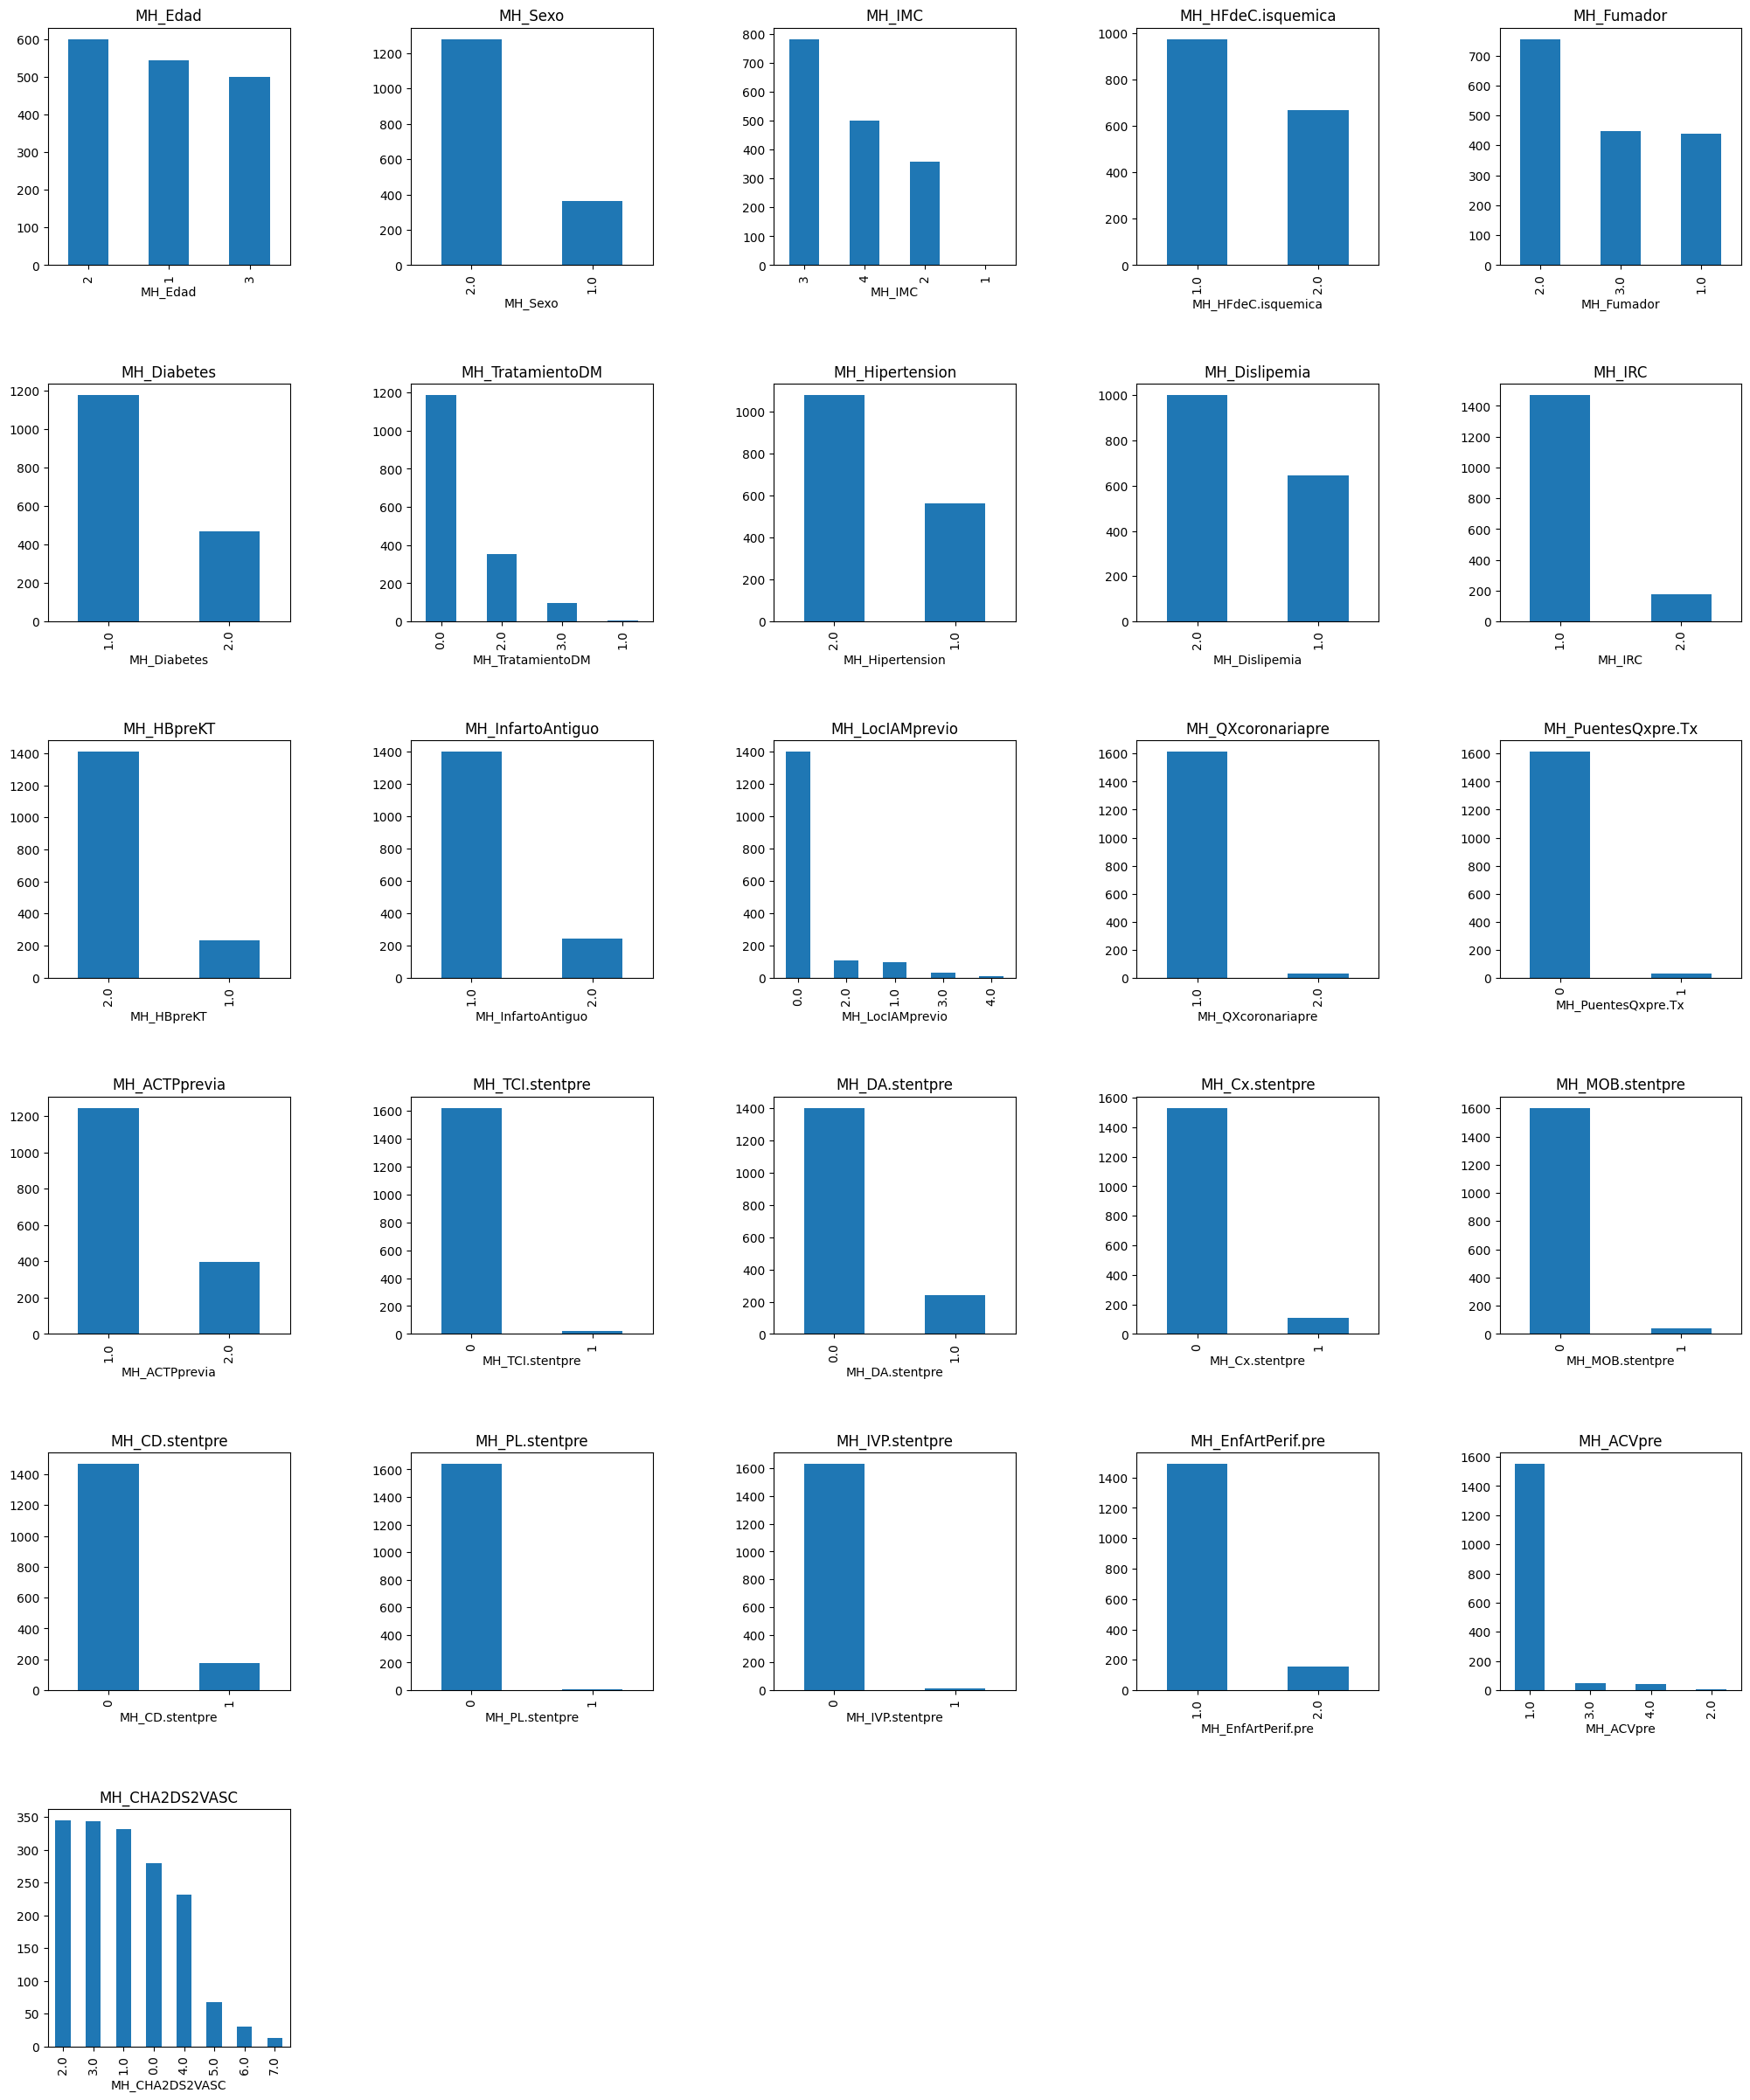

In [138]:
plot_variable_distributions(df_mh_nonulls, exclude_columns=['ID', 'MuerteCV', 'Revasc'])

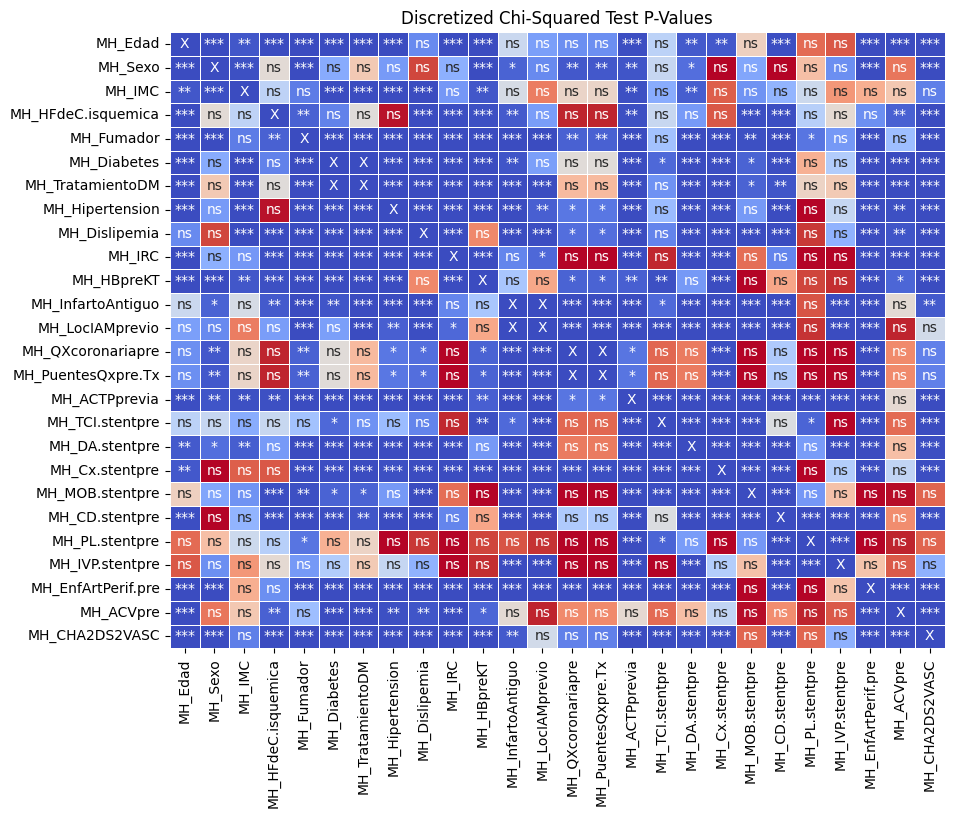

(                    ID        MH_Edad       MH_Sexo        MH_IMC  \
 ID                 NaN            NaN           NaN           NaN   
 MH_Edad            NaN   0.000000e+00  3.455696e-08  2.597250e-02   
 MH_Sexo            NaN   3.455696e-08  0.000000e+00  8.298041e-03   
 MH_IMC             NaN   2.597250e-02  8.298041e-03  0.000000e+00   
 MH_HFdeC.isquemica NaN   5.614395e-12  5.227423e-01  3.938798e-01   
 MH_Fumador         NaN   2.893405e-62  7.225016e-34  1.107838e-01   
 MH_Diabetes        NaN   1.278370e-11  2.378605e-01  5.279722e-07   
 MH_TratamientoDM   NaN   6.424379e-10  6.093092e-01  2.868838e-05   
 MH_Hipertension    NaN   1.650718e-32  1.909670e-01  6.619612e-12   
 MH_Dislipemia      NaN   1.484164e-01  9.200905e-01  1.026739e-03   
 MH_IRC             NaN   7.489413e-21  2.506050e-01  1.814386e-01   
 MH_HBpreKT         NaN   7.053452e-13  1.048092e-05  2.621083e-02   
 MH_InfartoAntiguo  NaN   4.333061e-01  5.351746e-02  4.719768e-01   
 MH_LocIAMprevio    

In [139]:
# We analyze the correlation between the variables
analyze_correlations(df_mh_nonulls, ignore_vars=['ID', 'MuerteCV', 'Revasc'])

In [140]:
# We create a contingency table between the variables MH_CHA2DS2VASC and MH_Edad
tabla_contingencia_1 = pd.crosstab(df_mh_nonulls['MH_CHA2DS2VASC'], df_mh_nonulls['MH_Edad'])
# We can see the contingency table
print(tabla_contingencia_1)

# As we increase the age group, the risk increases. Age is a very important risk factor. (SCORE: 2)

MH_Edad           1    2    3
MH_CHA2DS2VASC               
0.0             238   41    0
1.0             188  134   10
2.0              85  200   60
3.0              28  157  159
4.0               2   52  178
5.0               2    8   58
6.0               0    7   23
7.0               0    1   12


In [141]:
# We create a contingency table between the variables MH_CHA2DS2VASC and Hipertension
contingency_table_2 = pd.crosstab(df_mh_nonulls['MH_CHA2DS2VASC'], df_mh_nonulls['MH_Hipertension'])
print(contingency_table_2)
# Hipertension is a risk factor. (SCORE: 1)

MH_Hipertension  1.0  2.0
MH_CHA2DS2VASC           
0.0              276    3
1.0              142  190
2.0               99  246
3.0               34  310
4.0               10  222
5.0                2   66
6.0                1   29
7.0                0   13


In [142]:
# We create a contingency table between the variables MH_CHA2DS2VASC and Diabetes
contingency_table_3 = pd.crosstab(df_mh_nonulls['MH_CHA2DS2VASC'], df_mh_nonulls['MH_Diabetes'])
print(contingency_table_3)
# Diabetes mellitus is a risk factor. (SCORE: 1)

MH_Diabetes     1.0  2.0
MH_CHA2DS2VASC          
0.0             279    0
1.0             306   26
2.0             251   94
3.0             219  125
4.0             100  132
5.0              13   55
6.0               8   22
7.0               0   13


In [143]:
# We create a contingency table between the variables MH_CHA2DS2VASC and MH_Sexo
tabla_contingencia_4 = pd.crosstab(df_mh_nonulls['MH_CHA2DS2VASC'], df_mh_nonulls['MH_Sexo'])
# We can see the contingency table
print(tabla_contingencia_4)

# We have observed that within the CHA2DS2VASC score range of 4 to 7, the risk increases for females. (SCORE: 1)

MH_Sexo         1.0  2.0
MH_CHA2DS2VASC          
0.0              41  238
1.0              15  317
2.0              71  274
3.0              93  251
4.0              98  134
5.0              28   40
6.0               9   21
7.0               9    4


**PROCEDURE**

| Variable       | Original variable type        | Bin 1      | Bin 2      | Bin 3      | Bin 4      | Bin 5      | Bin 6      | Bin 7      | Bin 8      | Bin 9      |
|----------------|-------------------------------|------------|------------|------------|------------|------------|------------|------------|------------|------------|
| FE             | Quantitative Discrete Variable| 1 \(0-40\] | 2 \(41-49\]| 3 \(50-70\]|            |            |            |            |            |
| Indicacion     | Nominal Categorical Variable  |1 (Stable angina)|2 (Unstable angina)|3 (NSTEMI)|4 (STEMI)|5 (Silent ischemia)|6 (Ventricular dysfunction)|7 (Arrhythmias)| 8 (Valvular)|9 (Others)
| IndicacionIAMCEST|Nominal Categorical Variable | 0 (N/A)    |1 (Primaria)|2* (Rescate post fibrinolisis)|3* (Tardía >24h)|4* (Isquemia pos-infarto)| | | | |           | 
| Acceso         | Nominal Categorical Variable  | 1 (Femoral)| 2 (Radial) |            |            |            |            |            |            |
| TCI.Actual     | Nominal Categorical Variable  | 0 (No)     | 1 (Yes)    |            |            |            |            |            |            |
| DA.Actual      | Nominal Categorical Variable  | 0 (No)     | 1 (Yes)    |            |            |            |            |            |            |
| CX.Actual      | Nominal Categorical Variable  | 0 (No)     | 1 (Yes)    |            |            |            |            |            |            |
| CD.Actual      | Nominal Categorical Variable  | 0 (No)     | 1 (Yes)    |            |            |            |            |            |            |
| Mamaria.Actual | Nominal Categorical Variable  | 0 (No)     | 1 (Yes)    |            |            |            |            |            |            |
| Safena.Actual  | Nominal Categorical Variable  | 0 (No)     | 1 (Yes)    |            |            |            |            |            |            |
| TratDecidido   | Nominal Categorical Variable  | 1 (ACTP)   | 2 (Cirugía)| 3 (Conservador)|        |            |            |            |            |
| Puentes.Actual | Nominal Categorical Variable  | 0 (N/A)    | 1 (Otherwise, by the moment)| |      |            |            |            |            |
| ACVQX.Actual   | Nominal Categorical Variable  | 0 (N/A)    | 1 (No)     | 2 (Yes)    |            |            |            |            |            |
| InfartoQX.Actual|Nominal Categorical Variable  | 0 (N/A)    | 1 (No)     | 2 (Yes)    |            |            |            |            |            |
| MuerteQX.Actual|Nominal Categorical Variable   | 0 (N/A)    | 1 (No)     | 2 (Yes)    |            |            |            |            |            |
| MuerteQX.Texto | Empty                         |            |            |            |            |            |            |            |            |            |
| TCI.tratada    | Nominal Categorical Variable  | 0 (No)     | 1 (Yes)    |            |            |            |            |            |            |
| DA.tratada     | Nominal Categorical Variable  | 0 (No)     | 1 (Yes)    |            |            |            |            |            |            |
| Cx.tratada     | Nominal Categorical Variable  | 0 (No)     | 1 (Yes)    |            |            |            |            |            |            |
| CD.tratada     | Nominal Categorical Variable  | 0 (No)     | 1 (Yes)    |            |            |            |            |            |            |
| Mamaria.tratada| Nominal Categorical Variable  | 0 (No)     | 1 (Yes)    |            |            |            |            |            |            |
| Safena.tratada | Nominal Categorical Variable  | 0 (No)     | 1 (Yes)    |            |            |            |            |            |            |
|Lesiones Tratadas| Nominal Categorical Variable | 0          | 1          | 2          | 3          | 4          |            |            |            |
| SINTAX1        | Empty                         |            |            |            |            |            |            |            |            |            |
| SINTAX2        | Empty                         |            |            |            |            |            |            |            |            |            |

In [144]:
# We define a DataFrame with the columns of the procedures and we put a P in front of the columns to classify them
df_proc = df[['Id', 'Unnamed: 34', 'FE', 'Indicacion', 'IndicacionIAMCEST', 'Acceso', 'TCI.Actual', 'DA.Actual', 'CX.Actual', 'CD.Actual', 'Mamaria.Actual', 'Safena.Actual', 'TratDecidido', 'FechaQx.Actual', 'Puentes.Actual', 'ACVQX.Actual', 'InfartoQX.Actual', 'MuerteQX.Actual', 'MuerteQXtexto', 'TCI.tratada', 'DA.tratada', 'Cx.tratada', 'CD.tratada', 'Mamaria.tratada', 'Safena.tratada', 'Lesiones Tratadas', 'SINTAX1', 'SINTAX2']].rename(columns={'Id': 'ID', 'Unnamed: 34': 'P_Unnamed', 'FE': 'P_FE', 'Indicacion': 'P_Indicacion', 'IndicacionIAMCEST': 'P_IndicacionIAMCEST', 'Acceso': 'P_Acceso', 'TCI.Actual': 'P_TCI.Actual', 'DA.Actual': 'P_DA.Actual', 'CX.Actual': 'P_CX.Actual', 'CD.Actual': 'P_CD.Actual', 'Mamaria.Actual': 'P_Mamaria.Actual', 'Safena.Actual': 'P_Safena.Actual', 'TratDecidido': 'P_TratDecidido', 'FechaQx.Actual': 'P_FechaQx.Actual', 'Puentes.Actual': 'P_Puentes.Actual', 'ACVQX.Actual': 'P_ACVQX.Actual', 'InfartoQX.Actual': 'P_InfartoQX.Actual', 'MuerteQX.Actual': 'P_MuerteQX.Actual', 'MuerteQXtexto': 'P_MuerteQXtexto', 'TCI.tratada': 'P_TCI.tratada', 'DA.tratada': 'P_DA.tratada', 'Cx.tratada': 'P_Cx.tratada', 'CD.tratada': 'P_CD.tratada', 'Mamaria.tratada': 'P_Mamaria.tratada', 'Safena.tratada': 'P_Safena.tratada', 'Lesiones Tratadas': 'P_Lesiones_Tratadas', 'SINTAX1': 'P_SINTAX1', 'SINTAX2': 'P_SINTAX2'})

# We also add the columns "Muerte CV" and "Revasc" to the DataFrame
df_proc.loc[:, 'MuerteCV'] = df['Muerte CV']
df_proc.loc[:, 'Revasc'] = df['Revasc']

# We remove the column P_Unnamed
df_proc.drop('P_Unnamed', axis=1, inplace=True) # Date

# We discretize the column P_FE values less than 40, 1, between 41 and 49 2, between 50 and 70 3
df_proc.loc[:, 'P_FE'] = pd.cut(df_proc['P_FE'], bins=[df_proc['P_FE'].min()-1, 40, 49, 70, df_proc['P_FE'].max()], labels=[1, 2, 3, 4])

# We complete the missing values of IndicacionIAMCEST with 0
df_proc.loc[:, 'P_IndicacionIAMCEST'] = df_proc['P_IndicacionIAMCEST'].fillna(0)

# We delete P_Mamaria.Actual (all values are 0)
df_proc.drop('P_Mamaria.Actual', axis=1, inplace=True)

# We complete the missing values of Puentes.Actual with 0 (by the moment)
df_proc.loc[:, 'P_Puentes.Actual'] = df_proc['P_Puentes.Actual'].fillna(0)
df_proc.loc[df_proc['P_Puentes.Actual'] != 0, 'P_Puentes.Actual'] = 1

# We complete the missing values of ACVQX.Actual with 0 if the value of P_TratDecidido is 1 or 3
df_proc.loc[df_proc['P_TratDecidido'].isin([1, 3]), 'P_ACVQX.Actual'] = 0

# We complete the missing values of InfartoQX.Actual with 0 if the value of P_TratDecidido is 1 or 3
df_proc.loc[df_proc['P_TratDecidido'].isin([1, 3]), 'P_InfartoQX.Actual'] = 0

# We complete the columns P_MuerteQX.Actual with 0 if the value of P_TratDecidido is 1 or 3
df_proc.loc[df_proc['P_TratDecidido'].isin([1, 3]), 'P_MuerteQX.Actual'] = 0

# We delete P_Mamaria.Tratada (all values are 0)
df_proc.drop('P_Mamaria.tratada', axis=1, inplace=True)

# Eliminamos la columna Lesiones Tratadas
df_proc.drop('P_Lesiones_Tratadas', axis=1, inplace=True)

# We remove the columns that exceed 25% of null values
df_proc = remove_columns_nulls(df_proc, 0.25)

# We delete the rows that contain null values
df_proc_nonulls, n_rows = remove_rows_nulls(df_proc)
print("Number of records not used (with missing values):", n_rows)

count_variables_records(df_proc_nonulls)

df_proc.to_csv('procedures.csv', index=False)
df_proc_nonulls.to_csv('procedures_nonulls.csv', index=False)

# We print the unique values of the columns
for i in df_proc_nonulls.columns:
    print(i, df_proc_nonulls[i].unique())

# In this dataset the variables: MuerteQXtexto, SINTAX1, SINTAX2 have been discarded due to their large number of missing values.
# Unnamed: 34, FechaQx.Actual and Lesiones Tratadas have also been removed.

Number of records not used (with missing values): 812
Number of variables: 22
Number of records: 1666
ID [   1    2    4 ... 2476 2477 2478]
P_FE [2, 1, 3]
Categories (4, int64): [1 < 2 < 3 < 4]
P_Indicacion [4. 1. 3. 2. 8. 9. 6. 5. 7.]
P_IndicacionIAMCEST [1. 0. 3.]
P_Acceso [1. 2.]
P_TCI.Actual [0 1]
P_DA.Actual [1 0]
P_CX.Actual [1 0]
P_CD.Actual [1 0]
P_Safena.Actual [0 1]
P_TratDecidido [1. 3. 2.]
P_Puentes.Actual [0 1]
P_ACVQX.Actual [0. 1.]
P_InfartoQX.Actual [0. 1.]
P_MuerteQX.Actual [0. 1.]
P_TCI.tratada [0 1]
P_DA.tratada [1 0]
P_Cx.tratada [1 0]
P_CD.tratada [1 0]
P_Safena.tratada [0 1]
MuerteCV [0. 1.]
Revasc [1. 0. 5.]


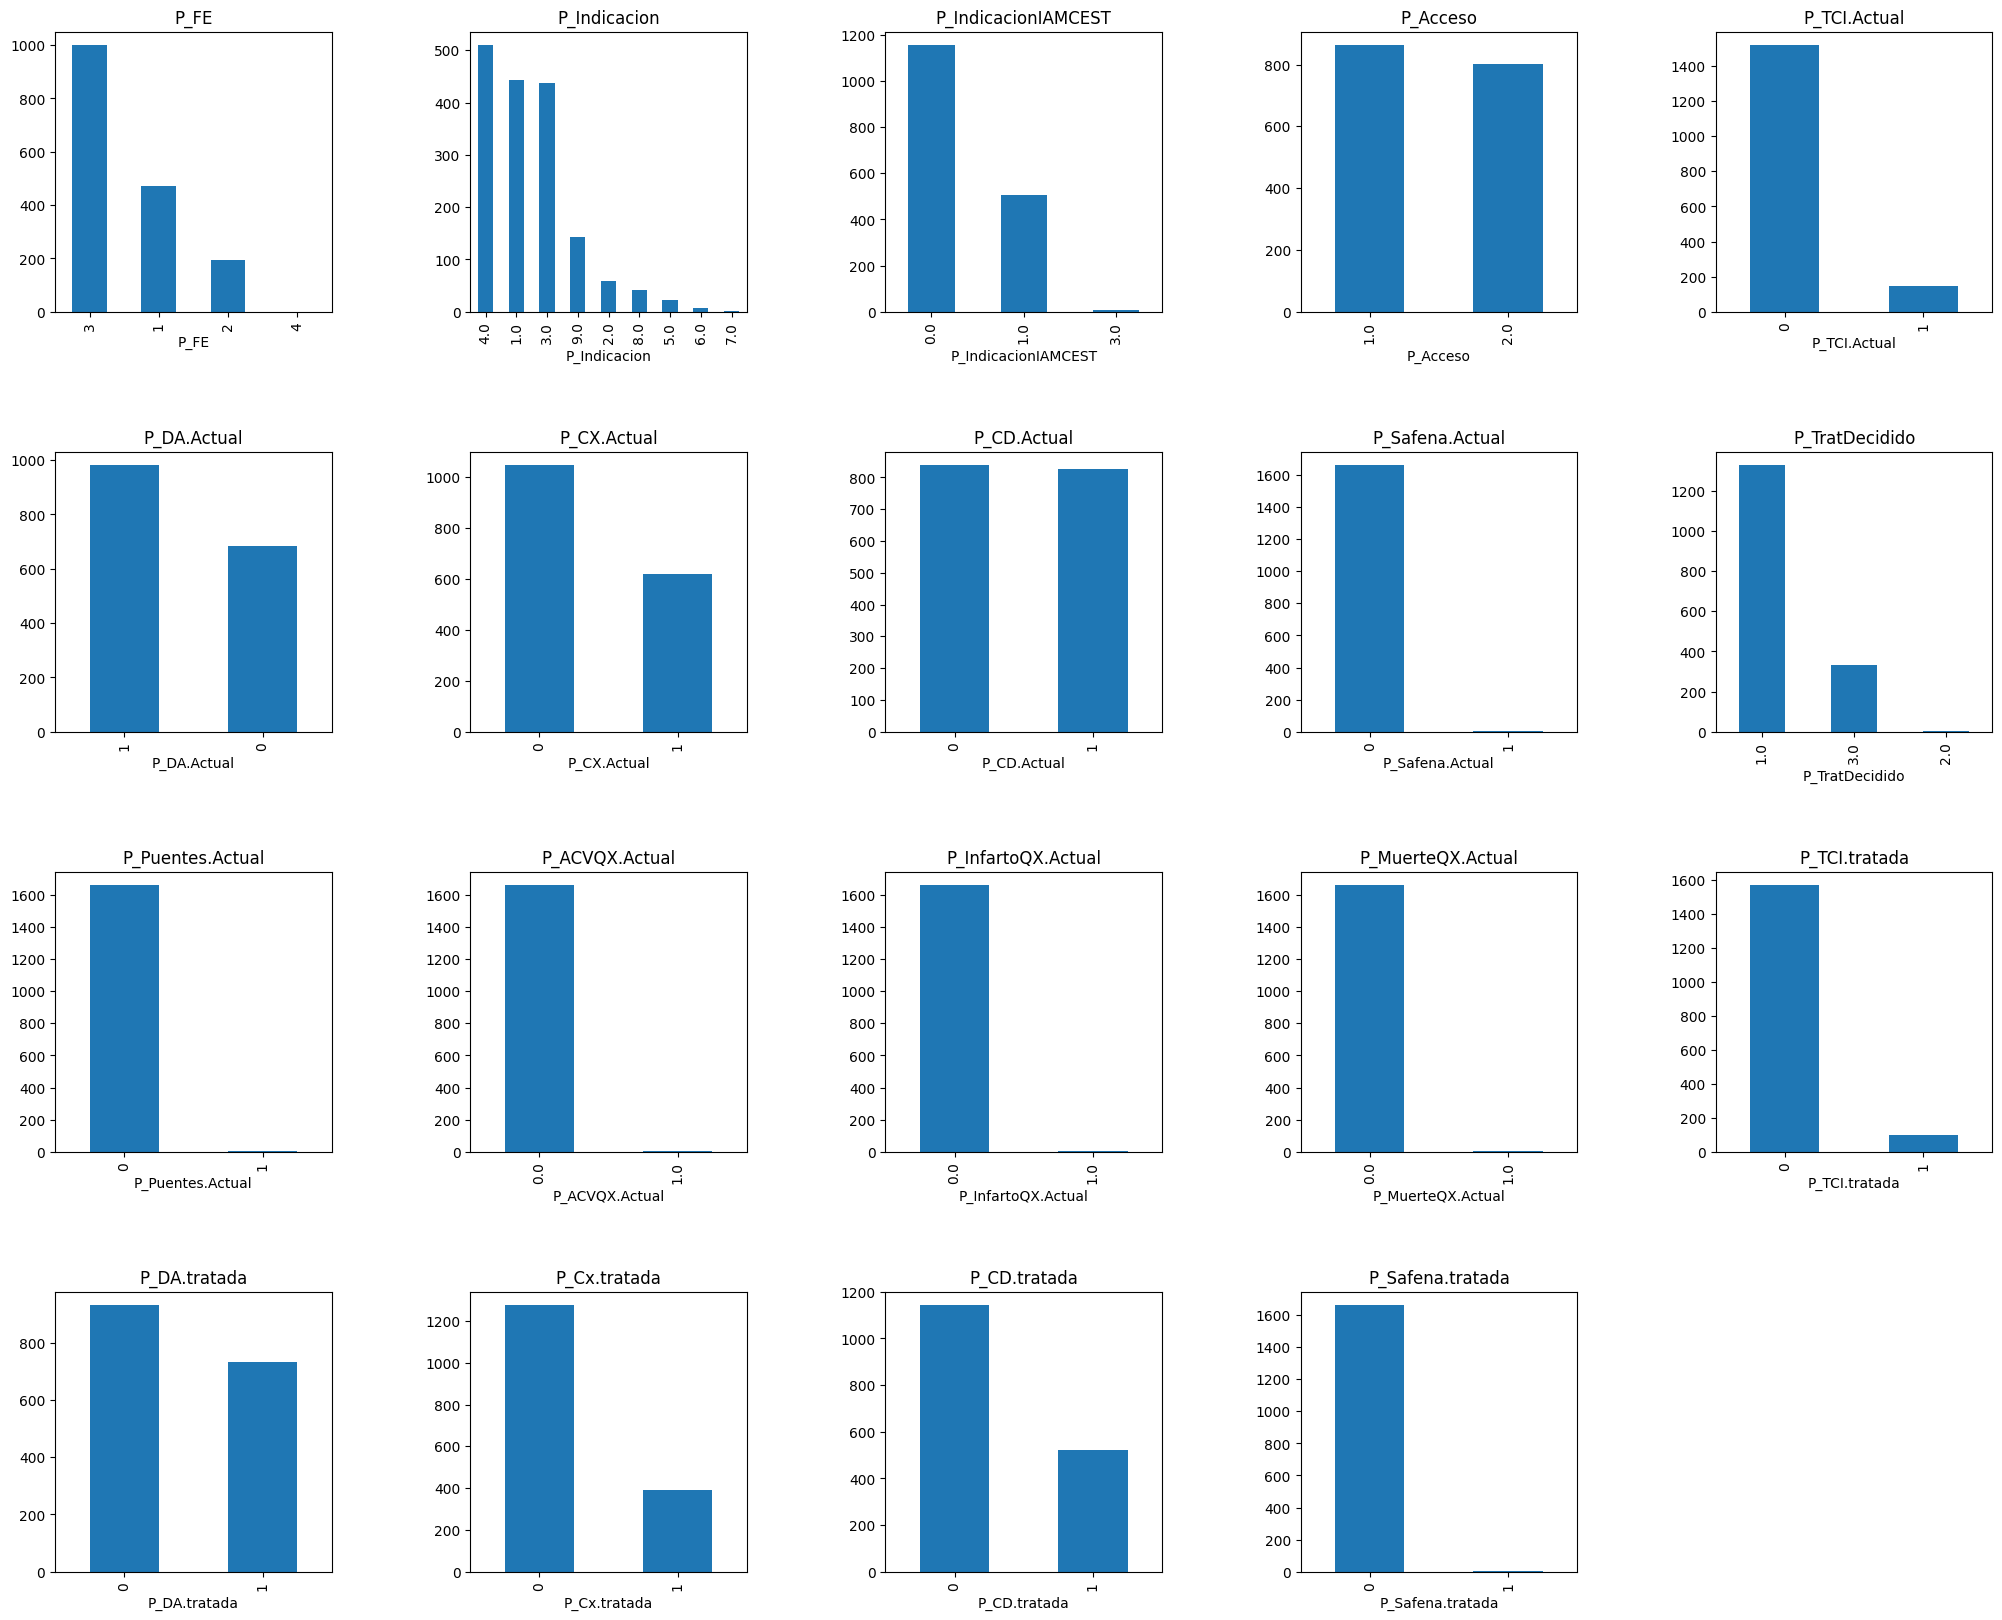

In [145]:
plot_variable_distributions(df_proc_nonulls, exclude_columns=['ID', 'MuerteCV', 'Revasc'])

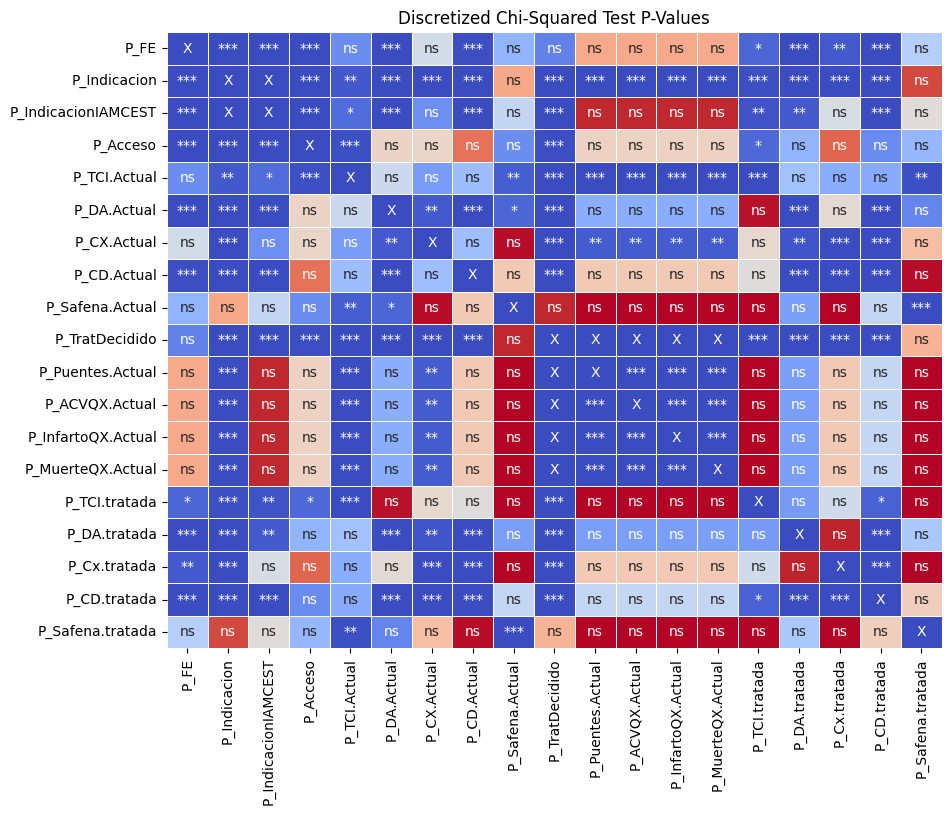

(                     ID          P_FE  P_Indicacion  P_IndicacionIAMCEST  \
 ID                  NaN           NaN           NaN                  NaN   
 P_FE                NaN  0.000000e+00  1.733077e-37         3.987120e-31   
 P_Indicacion        NaN  1.733077e-37  0.000000e+00         0.000000e+00   
 P_IndicacionIAMCEST NaN  3.987120e-31  0.000000e+00         0.000000e+00   
 P_Acceso            NaN  2.382188e-04  2.648434e-19         8.311180e-18   
 P_TCI.Actual        NaN  1.546707e-01  3.022944e-02         7.611806e-02   
 P_DA.Actual         NaN  3.595161e-09  9.529609e-05         6.790949e-04   
 P_CX.Actual         NaN  4.593158e-01  2.843566e-03         1.570535e-01   
 P_CD.Actual         NaN  7.619438e-03  2.442276e-03         1.357351e-03   
 P_Safena.Actual     NaN  2.631040e-01  7.133798e-01         4.129303e-01   
 P_TratDecidido      NaN  1.251248e-01  8.227580e-45         9.650221e-24   
 P_Puentes.Actual    NaN  7.089865e-01  9.829799e-10         9.659907e-01   

In [146]:
# We analyze the correlation between the variables
analyze_correlations(df_proc_nonulls, ignore_vars=['ID', 'MuerteCV', 'Revasc'])

**MEDICAL HISTORY + PROCEDURE**

In [147]:
df_mh_proc = pd.merge(df_mh.drop(columns=['MuerteCV', 'Revasc']), df_proc, on='ID')

# Remove rows with missing values
df_mh_proc_nonulls, n_rows = remove_rows_nulls(df_mh_proc)
print("Number of records not used (with missing values):", n_rows)

count_variables_records(df_mh_proc_nonulls)

df_mh_proc.to_csv('medicalhistory_procedures.csv', index=False)
df_mh_proc_nonulls.to_csv('medicalhistory_procedures_nonulls.csv', index=False)

# Print unique values of each column
for col in df_mh_proc_nonulls.columns:
    print(col, df_mh_proc_nonulls[col].unique())

Number of records not used (with missing values): 1003
Number of variables: 48
Number of records: 1475
ID [   2    4    5 ... 2476 2477 2478]
MH_Edad [3, 2, 1]
Categories (3, int64): [1 < 2 < 3]
MH_Sexo [2. 1.]
MH_IMC [4, 3, 2, 1]
Categories (4, int64): [1 < 2 < 3 < 4]
MH_HFdeC.isquemica [1. 2.]
MH_Fumador [3. 2. 1.]
MH_Diabetes [1. 2.]
MH_TratamientoDM [0. 3. 2. 1.]
MH_Hipertension [2. 1.]
MH_Dislipemia [1. 2.]
MH_IRC [1. 2.]
MH_HBpreKT [2. 1.]
MH_InfartoAntiguo [1. 2.]
MH_LocIAMprevio [0. 2. 3. 1. 4.]
MH_QXcoronariapre [1. 2.]
MH_PuentesQxpre.Tx [0 1]
MH_ACTPprevia [1. 2.]
MH_TCI.stentpre [0 1]
MH_DA.stentpre [0. 1.]
MH_Cx.stentpre [0 1]
MH_MOB.stentpre [0 1]
MH_CD.stentpre [0 1]
MH_PL.stentpre [0 1]
MH_IVP.stentpre [0 1]
MH_EnfArtPerif.pre [1. 2.]
MH_ACVpre [1. 4. 3. 2.]
MH_CHA2DS2VASC [2. 4. 3. 1. 0. 5. 7. 6.]
P_FE [1, 2, 3]
Categories (4, int64): [1 < 2 < 3 < 4]
P_Indicacion [4. 1. 2. 9. 8. 6. 3. 5. 7.]
P_IndicacionIAMCEST [1. 0. 3.]
P_Acceso [1. 2.]
P_TCI.Actual [0 1]
P_DA.Actual

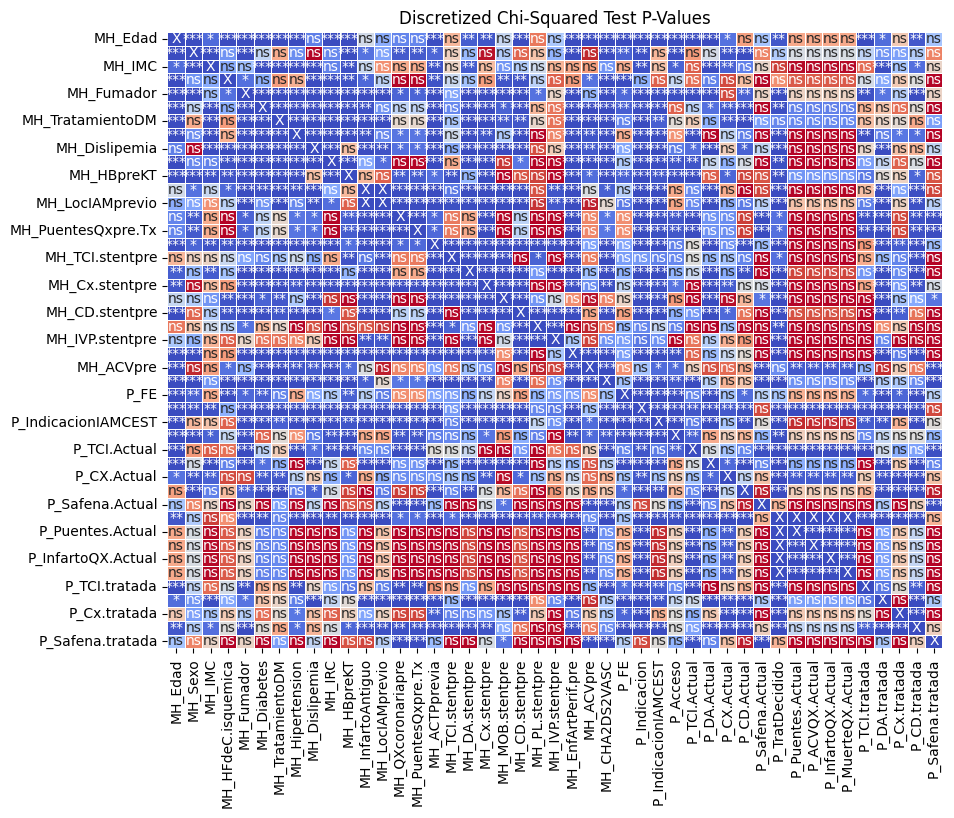

(                     ID        MH_Edad       MH_Sexo        MH_IMC  \
 ID                  NaN            NaN           NaN           NaN   
 MH_Edad             NaN   0.000000e+00  1.485023e-06  7.260069e-02   
 MH_Sexo             NaN   1.485023e-06  0.000000e+00  3.293760e-03   
 MH_IMC              NaN   7.260069e-02  3.293760e-03  0.000000e+00   
 MH_HFdeC.isquemica  NaN   7.852270e-11  1.698799e-01  2.421605e-01   
 MH_Fumador          NaN   4.386318e-55  9.156381e-29  3.040821e-01   
 MH_Diabetes         NaN   3.285265e-12  4.002430e-01  1.404711e-05   
 MH_TratamientoDM    NaN   3.259686e-10  7.013673e-01  6.551771e-04   
 MH_Hipertension     NaN   6.267745e-30  1.548621e-01  5.576213e-11   
 MH_Dislipemia       NaN   1.175935e-01  1.000000e+00  3.327282e-03   
 MH_IRC              NaN   5.038307e-19  1.399840e-01  1.259822e-01   
 MH_HBpreKT          NaN   1.324693e-11  5.112103e-06  1.311891e-02   
 MH_InfartoAntiguo   NaN   4.543543e-01  8.603534e-02  4.238280e-01   
 MH_Lo

In [148]:
# We analyze the correlation between the variables
analyze_correlations(df_mh_proc_nonulls, ignore_vars=['ID', 'MuerteCV', 'Revasc'])

**ADMISSION**

| Variable       | Original variable type        | Bin 1      | Bin 2      | Bin 3      | Bin 4      | Bin 5      | Bin 6      | Bin 7      | Bin 8      | Bin 9      |
|----------------|-------------------------------|------------|------------|------------|------------|------------|------------|------------|------------|------------|
| Complicaciones | Nominal Categorical Variable  | 1 (No)     | 2 (Yes)    |            |            |            |            |            |            |            |
| CreaPost       | Quantitative Discrete Variable| 0 (Bad levels) | 1 (Good levels)|    |            |            |            |            |            |            |
| HBpost         | Quantitative Discrete Variable| 1 (<12.1, >17.2)| 2 (Normal range)|  |            |            |            |            |            |            |
| VivoAlta       | Nominal Categorical Variable  | 1 (No)     | 2 (Yes)    |            |            |            |            |            |            |            |
| Shock.Comp     | Nominal Categorical Variable  | 1 (No)     | 2 (Yes)    |            |            |            |            |            |            |            |
|TromboStent.Comp| Nominal Categorical Variable  | 1 (No)     | 2 (Yes)    |            |            |            |            |            |            |            |
|IAMxOtraLesión.Comp Nominal Categorical Variable| 1 (No)     | 2 (Yes)    |            |            |            |            |            |            |            |
|reACTPmismo.Comp| Nominal Categorical Variable  | 1 (No)     | 2 (Yes)    |            |            |            |            |            |            |            |
|CirugiaCoro.Comp| Nominal Categorical Variable  | 1 (No)     | 2 (Yes)    |            |            |            |            |            |            |            |
|Hemorragia.Comp | Nominal Categorical Variable  | 1 (No)     | 2 (Yes)    |            |            |            |            |            |            |            |
| Infeccion.Comp | Nominal Categorical Variable  | 1 (No)     | 2 (Yes)    |            |            |            |            |            |            |            |
| AccesoVasc.Comp| Nominal Categorical Variable  | 1 (No)     | 2 (Yes)    |            |            |            |            |            |            |            |
|   Otras.Comp   | Nominal Categorical Variable  | 1 (No)     | 2 (Yes)    |            |            |            |            |            |            |            |
|   Adiro        | Nominal Categorical Variable  | 1 (No)     | 2 (Yes)    |            |            |            |            |            |            |            |
|DuracionAdiro   | Nominal Categorical Variable  | 1 (1 mes)  | 2 (3 meses)| 3 (6 meses)|4 (12 meses)|5 (Indefinida)|          |            |            |            |
| InhibADP       | Nominal Categorical Variable  | 1 (No)     |2 (Clopidogrel)|3 (Tricagrelor)|4 (Prasugrel)|     |            |            |            |            |
|DuracionInhADP  | Nominal Categorical Variable  | 0 (N/A)    |1 (1 mes)  | 2 (3 meses)| 3 (6 meses)|4 (12 meses)|5 (Indefinida)|           |            |            |
| ACO            | Nominal Categorical Variable  | 1 (No)     |2 (Sintrom)|3 (Dabigatrán)|4 (Rivaroxabán)|5 (Apixabán)|5 (Edoxabán)|        |            |            |
|DuracionACO     | Nominal Categorical Variable  | 0 (N/A)    |1 (1 mes)  | 2 (3 meses)| 3 (6 meses)|4 (12 meses)|5 (Indefinida)|           |            |            |

In [149]:
# We define a DataFrame with the columns of the admission and we put ADM in front of the columns to classify them
df_adm = df[['Id', 'Complicaciones', 'CreaPost', 'HBpost', 'VivoAlta', 'FechaMuerteAlta', 'CausaMuerteAlta', 'Shock.Comp', 'TromboStent.Comp', 'IAMxOtraLesión.Comp', 'reACTPmismo.Comp', 'reACTPnueva.Comp', 'CirugiaCoro.Comp', 'Hemorragia.Comp', 'Infeccion.Comp', 'AccesoVasc.Comp', 'Otras.Comp', 'Adiro', 'DuracionAdiro', 'InhibADP', 'DuracionInhADP', 'ACO', 'DuracionACO']].rename(columns={'Id': 'ID', 'Complicaciones': 'ADM_Complicaciones', 'CreaPost': 'ADM_CreaPost', 'HBpost': 'ADM_HBpost', 'VivoAlta': 'ADM_VivoAlta', 'FechaMuerteAlta': 'ADM_FechaMuerteAlta', 'CausaMuerteAlta': 'ADM_CausaMuerteAlta', 'Shock.Comp': 'ADM_Shock.Comp', 'TromboStent.Comp': 'ADM_TromboStent.Comp', 'IAMxOtraLesión.Comp': 'ADM_IAMxOtraLesión.Comp', 'reACTPmismo.Comp': 'ADM_reACTPmismo.Comp', 'reACTPnueva.Comp': 'ADM_reACTPnueva.Comp', 'CirugiaCoro.Comp': 'ADM_CirugiaCoro.Comp', 'Hemorragia.Comp': 'ADM_Hemorragia.Comp', 'Infeccion.Comp': 'ADM_Infeccion.Comp', 'AccesoVasc.Comp': 'ADM_AccesoVasc.Comp', 'Otras.Comp': 'ADM_Otras.Comp', 'Adiro': 'ADM_Adiro', 'DuracionAdiro': 'ADM_DuracionAdiro', 'InhibADP': 'ADM_InhibADP', 'DuracionInhADP': 'ADM_DuracionInhADP', 'ACO': 'ADM_ACO', 'DuracionACO': 'ADM_DuracionACO'})

# We also add the columns "Muerte CV" and "Revasc" to the DataFrame
df_adm.loc[:, 'MuerteCV'] = df['Muerte CV']
df_adm.loc[:, 'Revasc'] = df['Revasc']

# We discretize the variable CreaPost 0 for values < 0.5 or > 1.2 2, 1 otherwise
df_adm.loc[:, 'ADM_CreaPost'] = df_adm['ADM_CreaPost'].apply(lambda x: 0 if x < 0.5 or x > 1.2 else 1)

# We discretize the variable MH_HBpost, 1 if it is below 12.1 or above 17.2, 2 otherwise
df_adm.loc[:, 'ADM_HBpost'] = df_adm['ADM_HBpost'].apply(lambda x: 1 if x < 12.1 or x > 17.2 else 2)

# We remove the column FechaMuerteAlta too many missing values
df_adm.drop('ADM_FechaMuerteAlta', axis=1, inplace=True)

# We remove the column CausaMuerteAlta too many missing values
df_adm.drop('ADM_CausaMuerteAlta', axis=1, inplace=True)

# We remove the column reACTPnueva.Comp (all values are 0)
df_adm.drop('ADM_reACTPnueva.Comp', axis=1, inplace=True)

# For the missing values of Otras.Comp we put a 0, and where there is a value a 1
df_adm.loc[df_adm['ADM_Otras.Comp'].notnull(), 'ADM_Otras.Comp'] = 1
df_adm.loc[df_adm['ADM_Otras.Comp'].isnull(), 'ADM_Otras.Comp'] = 0

# We put 0 in DuracionInhADP if InhibADP is 1
df_adm.loc[df_adm['ADM_InhibADP'] == 1, 'ADM_DuracionInhADP'] = 0

# We put 0 in DuracionACO is ACO is 1
df_adm.loc[df_adm['ADM_ACO'] == 1, 'ADM_DuracionACO'] = 0

# We remove the columns that exceed 25% of null values
df_adm = remove_columns_nulls(df_adm, 0.25)

# We delete the rows that contain null values
df_adm_nonulls, n_rows = remove_rows_nulls(df_adm)
print("Number of records with missing values:", n_rows)

count_variables_records(df_adm_nonulls)

df_adm.to_csv('admission.csv', index=False)
df_adm_nonulls.to_csv('admission_nonulls.csv', index=False)

# We print the unique values of the columns
for i in df_adm_nonulls.columns:
    print(i, df_adm_nonulls[i].unique())

# In this dataset the variables: FechaMuerteAlta and CausaMuerteAlta have been discarded due to their large number of missing values.
# reACTPnueva.Comp has also been removed.

Number of records with missing values: 1533
Number of variables: 22
Number of records: 945
ID [  15   16   35   44   50   52   53   54   55   56   57   58   59   61
   66   69   70   74   75   76   77   78   80   82   83   84   85   86
   87   88   90   92   96   97   98   99  101  104  105  106  107  108
  109  111  113  115  116  117  121  122  123  124  125  128  129  130
  131  132  133  135  136  137  138  139  140  142  143  144  145  146
  147  148  149  151  152  155  156  157  158  159  160  162  163  164
  165  166  168  169  170  171  172  173  174  176  178  179  181  184
  185  186  188  189  190  191  192  193  194  195  196  197  198  200
  201  202  203  204  206  207  209  210  211  212  213  214  215  216
  217  219  220  221  222  223  224  225  226  227  228  229  230  231
  232  233  234  235  236  237  238  240  241  242  243  244  245  246
  247  248  249  250  251  252  253  254  255  256  257  258  259  261
  262  263  264  265  266  267  268  269  270  271  27

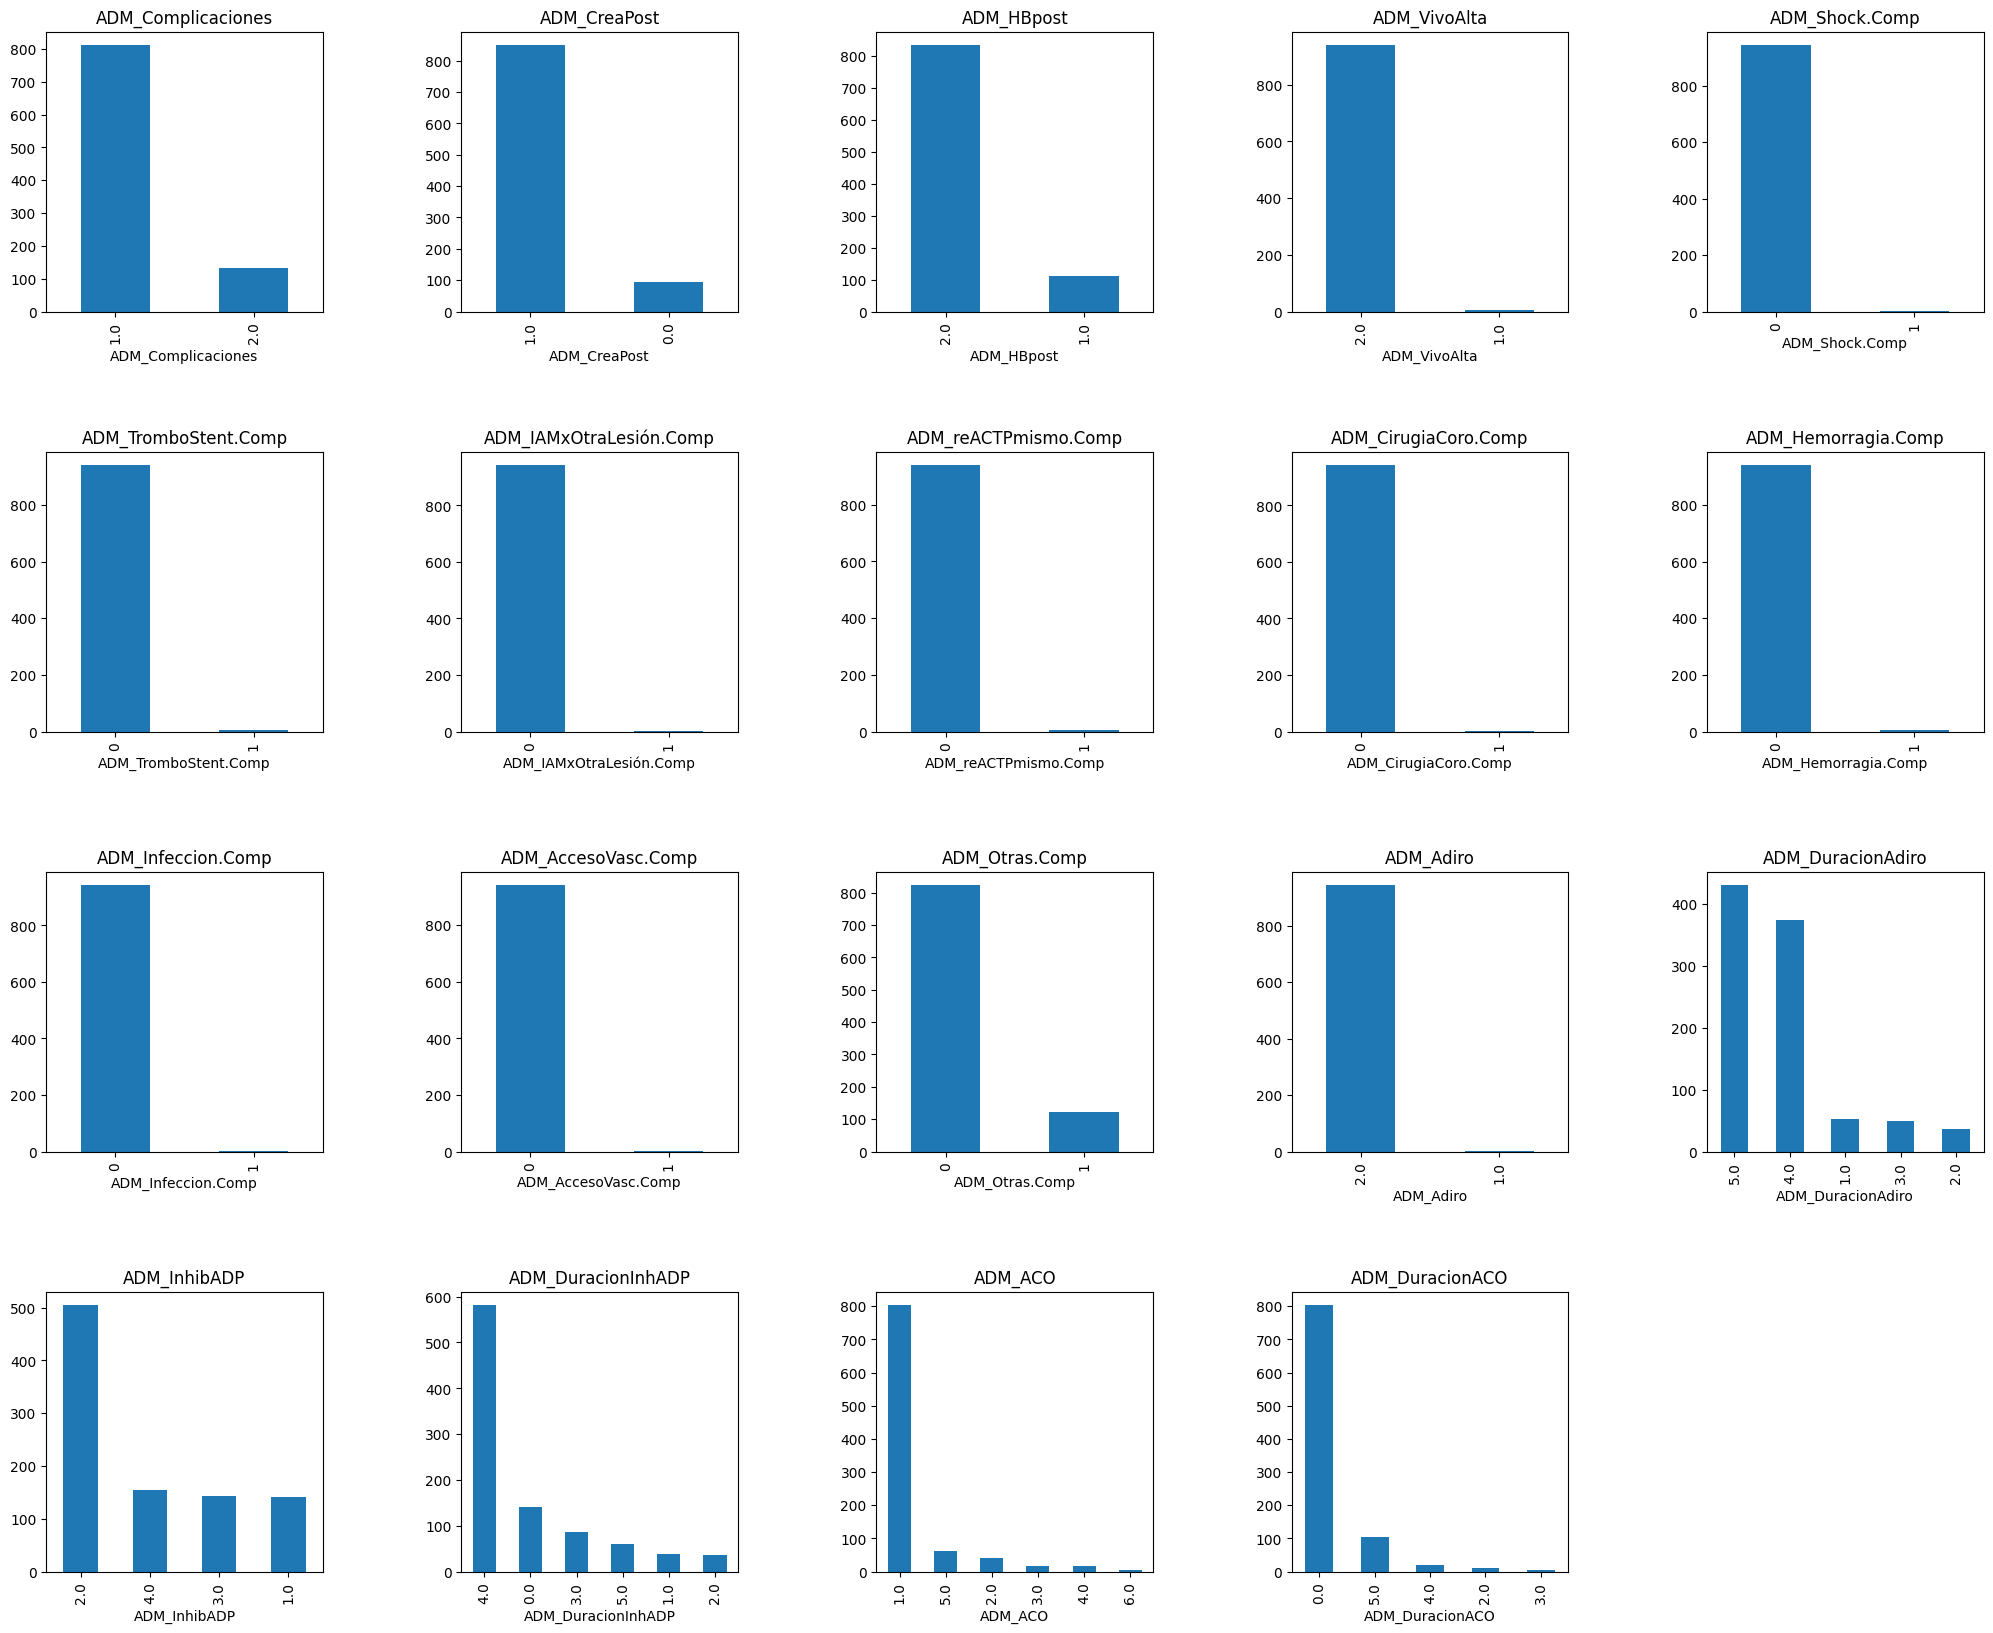

In [150]:
plot_variable_distributions(df_adm_nonulls, exclude_columns=['ID', 'MuerteCV', 'Revasc'])

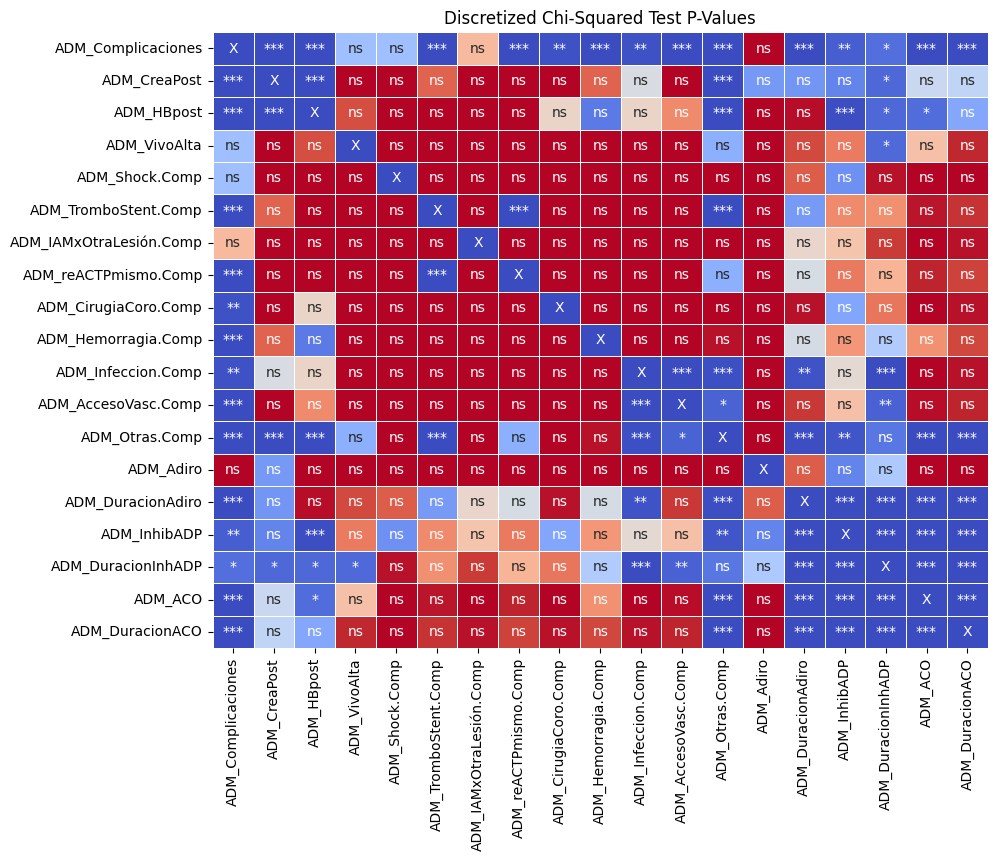

(                         ID  ADM_Complicaciones  ADM_CreaPost    ADM_HBpost  \
 ID                      NaN                 NaN           NaN           NaN   
 ADM_Complicaciones      NaN        0.000000e+00  4.419654e-05  6.907922e-07   
 ADM_CreaPost            NaN        4.419654e-05  0.000000e+00  5.373436e-12   
 ADM_HBpost              NaN        6.907922e-07  5.373436e-12  0.000000e+00   
 ADM_VivoAlta            NaN        3.045327e-01  9.968524e-01  9.087110e-01   
 ADM_Shock.Comp          NaN        3.013083e-01  1.000000e+00  1.000000e+00   
 ADM_TromboStent.Comp    NaN        2.317948e-05  8.704375e-01  1.000000e+00   
 ADM_IAMxOtraLesión.Comp NaN        6.564669e-01  1.000000e+00  1.000000e+00   
 ADM_reACTPmismo.Comp    NaN        9.829247e-07  1.000000e+00  1.000000e+00   
 ADM_CirugiaCoro.Comp    NaN        1.312699e-02  1.000000e+00  5.553593e-01   
 ADM_Hemorragia.Comp     NaN        2.317948e-05  8.704375e-01  1.060727e-01   
 ADM_Infeccion.Comp      NaN        1.31

In [151]:
# We analyze the correlation between the variables
analyze_correlations(df_adm_nonulls, ignore_vars=['ID', 'MuerteCV', 'Revasc'])

**MEDICAL HISTORY + PROCEDURE + ADMISSION**

In [171]:
# Now we merge the three datasets Medical History, Procedures and Admission
df_mh_proc_adm = pd.merge(df_mh_proc.drop(columns=['MuerteCV', 'Revasc']), df_adm, on='ID')

# Eliminamos la columna P_Puentes.Actual
df_mh_proc_adm.drop('P_Puentes.Actual', axis=1, inplace=True)

# Eliminamos la columna P_ACVQX
df_mh_proc_adm.drop('P_ACVQX.Actual', axis=1, inplace=True)

# Remove rows with missing values
df_mh_proc_adm_nonulls, n_rows = remove_rows_nulls(df_mh_proc_adm)
print("Number of records not used (with missing values):", n_rows)

count_variables_records(df_mh_proc_adm_nonulls)

# Save the dataframes to CSV files
df_mh_proc_adm.to_csv('medicalhistory_procedures_admission.csv', index=False)
df_mh_proc_adm_nonulls.to_csv('medicalhistory_procedures_admission_nonulls.csv', index=False)

# Print unique values of each column
for col in df_mh_proc_adm_nonulls.columns:
    print(col, df_mh_proc_adm_nonulls[col].unique())


Number of records not used (with missing values): 1715
Number of variables: 65
Number of records: 763
ID [  15   16   35   44   50   52   54   55   56   57   58   59   61   66
   69   70   74   75   77   78   82   83   84   85   86   87   88   92
   96   97   98   99  101  104  105  106  108  109  113  116  117  121
  122  124  125  128  129  130  131  132  133  135  136  137  138  139
  140  143  144  145  146  147  148  149  151  152  155  156  158  159
  160  162  163  164  165  166  168  169  171  174  179  181  184  186
  189  191  192  193  194  195  197  200  201  202  203  204  206  207
  210  211  213  214  215  216  217  219  220  221  223  224  225  226
  227  228  229  231  232  234  235  236  237  238  240  241  242  243
  244  245  247  248  250  251  252  254  255  256  257  262  263  264
  266  267  268  269  270  271  274  275  276  277  286  287  288  289
  290  291  293  294  295  296  297  300  301  302  305  307  308  310
  311  312  313  314  315  316  319  321  3

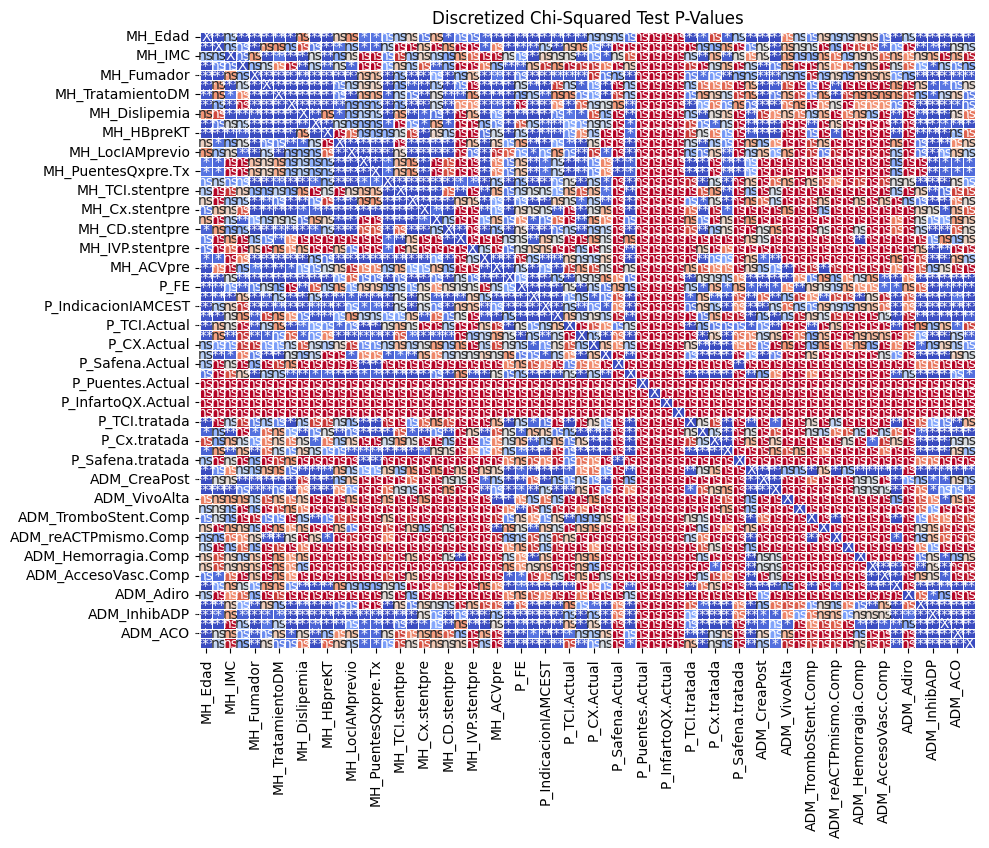

(                    ID       MH_Edad   MH_Sexo    MH_IMC  MH_HFdeC.isquemica  \
 ID                 NaN           NaN       NaN       NaN                 NaN   
 MH_Edad            NaN  0.000000e+00  0.000596  0.341277        6.804680e-08   
 MH_Sexo            NaN  5.963112e-04  0.000000  0.310485        1.423682e-01   
 MH_IMC             NaN  3.412768e-01  0.310485  0.000000        1.060072e-01   
 MH_HFdeC.isquemica NaN  6.804680e-08  0.142368  0.106007        0.000000e+00   
 ...                 ..           ...       ...       ...                 ...   
 ADM_DuracionInhADP NaN  1.612215e-10  0.007699  0.996082        3.550843e-01   
 ADM_ACO            NaN  4.145733e-07  0.477705  0.699120        1.460861e-01   
 ADM_DuracionACO    NaN  2.604660e-08  0.409468  0.980753        2.522343e-01   
 MuerteCV           NaN           NaN       NaN       NaN                 NaN   
 Revasc             NaN           NaN       NaN       NaN                 NaN   
 
                       MH_

In [153]:
# We analyze the correlation between the variables
analyze_correlations(df_mh_proc_adm_nonulls, ignore_vars=['ID', 'MuerteCV', 'Revasc'])

**FOLLOW-UP**

| Variable       | Original variable type        | Bin 1      | Bin 2      | Bin 3      | Bin 4      | Bin 5      | Bin 6      | Bin 7      | Bin 8      | Bin 9      |
|----------------|-------------------------------|------------|------------|------------|------------|------------|------------|------------|------------|------------|
| SegTelef12m    | Nominal Categorical Variable  | 1 (No)     | 2 (Yes)    |            |            |            |            |            |            |            |
| NosegTx        | Empty                         |            |            |            |            |            |            |            |            |            |
| FechaContacto  | Quantitative Discrete Variable| TO DO      |            |            |            |            |            |            |            |            |
| EstadoAnginoso | Empty                         |            |            |            |            |            |            |            |            |            |
| ClaseCCS       | Empty                         |            |            |            |            |            |            |            |            |            |
| Adiro12m       | Nominal Categorical Variable  | 1 (No)     | 2 (Yes)    |            |            |            |            |            |            |            |
| InhibADP12m    | Nominal Categorical Variable  | 1 (No)     |2 (Clopidogrel)|3 (Tricagrelor)|4 (Prasugrel)|     |            |            |            |            |
| ACO12m         | Nominal Categorical Variable  | 1 (No)     |2 (Sintrom)|3 (Dabigatrán)|4 (Rivaroxabán)|5 (Apixabán)|5 (Edoxabán)|        |            |            |
| DAPT.Score     | Empty                         |            |            |            |            |            |            |            |            |            |

In [154]:
# We define a DataFrame with the columns of the follow-up and we put FOL in front of the columns to classify them
df_fol = df[['Id', 'SegTelef12m', 'NosegTx', 'FechaContacto', 'EstadoAnginoso', 'ClaseCCS', 'Adiro12m', 'InhibADP12m', 'ACO12m', 'DAPT.Score']].rename(columns={'Id': 'ID', 'SegTelef12m': 'FOL_SegTelef12m', 'NosegTx': 'FOL_NosegTx', 'FechaContacto': 'FOL_FechaContacto', 'EstadoAnginoso': 'FOL_EstadoAnginoso', 'ClaseCCS': 'FOL_ClaseCCS', 'Adiro12m': 'FOL_Adiro12m', 'InhibADP12m': 'FOL_InhibADP12m', 'ACO12m': 'FOL_ACO12m', 'DAPT.Score': 'FOL_DAPT.Score'})

# We also add the columns "Muerte CV" and "Revasc" to the DataFrame
df_fol.loc[:, 'MuerteCV'] = df['Muerte CV']
df_fol.loc[:, 'Revasc'] = df['Revasc']

# We remove the column FOL_SegTelef12m too many missing values
df_fol.drop('FOL_SegTelef12m', axis=1, inplace=True)

# We remove the column FOL_NosegTx too many missing values
df_fol.drop('FOL_NosegTx', axis=1, inplace=True)

# We remove the column FechaContacto
df_fol.drop('FOL_FechaContacto', axis=1, inplace=True)

# We remove the column EstadoAnginoso too many missing values
df_fol.drop('FOL_EstadoAnginoso', axis=1, inplace=True)

# We remove the column FOL_ClaseCCS too many missing values
df_fol.drop('FOL_ClaseCCS', axis=1, inplace=True)

# We remove the column FOL_DAPT.Score too many missing values
df_fol.drop('FOL_DAPT.Score', axis=1, inplace=True)

# We remove the columns that exceed 25% of null values
df_fol = remove_columns_nulls(df_fol, 0.25)

# We delete the rows that contain null values
df_fol_nonulls, n_rows = remove_rows_nulls(df_fol)
print("Number of records with missing values:", n_rows)

count_variables_records(df_fol_nonulls)

df_fol.to_csv('followup.csv', index=False)
df_fol_nonulls.to_csv('followup_nonulls.csv', index=False)

# We print the unique values of the columns
for i in df_fol_nonulls.columns:
    print(i, df_fol_nonulls[i].unique())

Number of records with missing values: 1207
Number of variables: 5
Number of records: 1271
ID [   1    2    4 ... 2476 2477 2478]
FOL_Adiro12m [2. 1.]
FOL_InhibADP12m [1. 3. 2. 4.]
MuerteCV [0. 1.]
Revasc [1. 0. 5.]


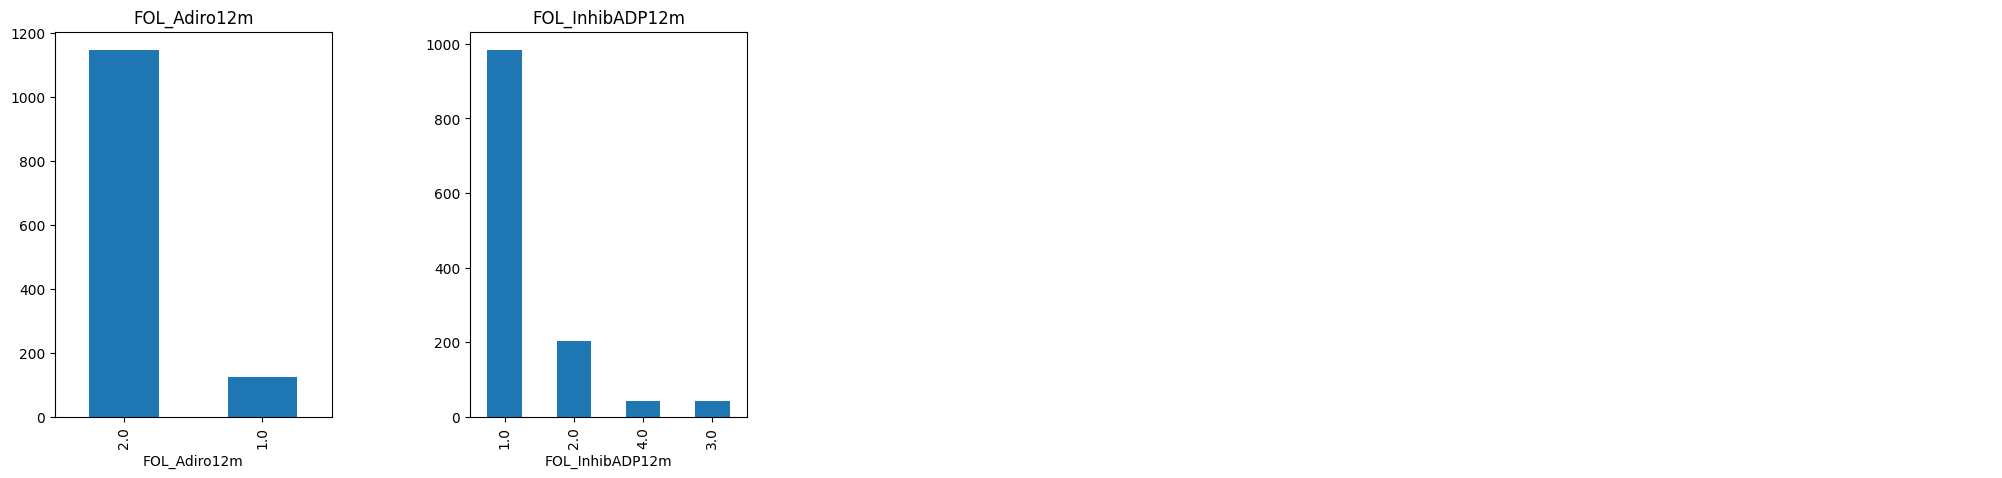

In [155]:
plot_variable_distributions(df_fol_nonulls, exclude_columns=['ID', 'MuerteCV', 'Revasc'])

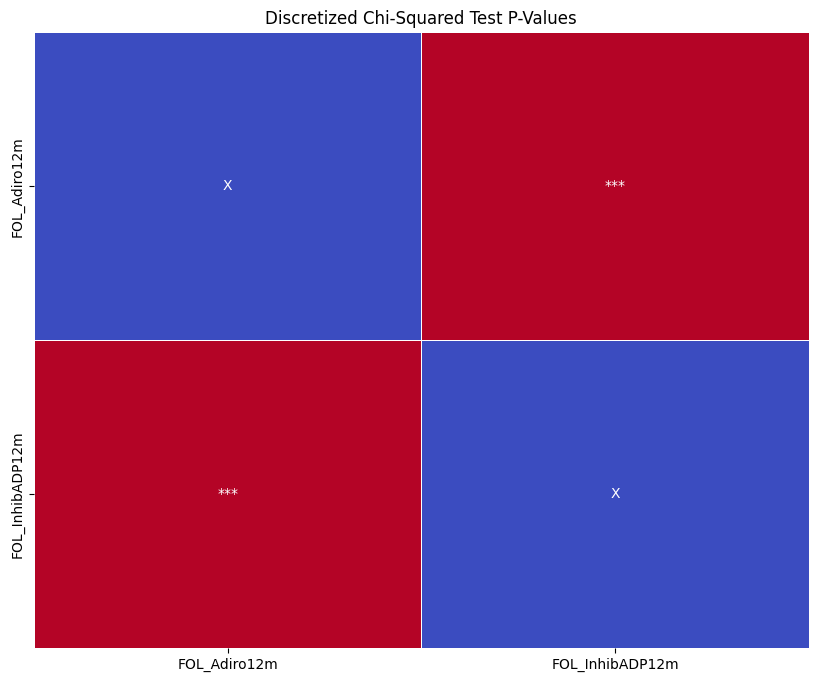

(                 ID  FOL_Adiro12m  FOL_InhibADP12m  MuerteCV  Revasc
 ID              NaN           NaN              NaN       NaN     NaN
 FOL_Adiro12m    NaN  0.000000e+00     2.698905e-29       NaN     NaN
 FOL_InhibADP12m NaN  2.698905e-29     0.000000e+00       NaN     NaN
 MuerteCV        NaN           NaN              NaN       NaN     NaN
 Revasc          NaN           NaN              NaN       NaN     NaN,
                  ID FOL_Adiro12m FOL_InhibADP12m MuerteCV Revasc
 ID               ns           ns              ns       ns     ns
 FOL_Adiro12m     ns            X             ***       ns     ns
 FOL_InhibADP12m  ns          ***               X       ns     ns
 MuerteCV         ns           ns              ns       ns     ns
 Revasc           ns           ns              ns       ns     ns)

In [156]:
# We analyze the correlation between the variables
analyze_correlations(df_fol_nonulls, ignore_vars=['ID', 'MuerteCV', 'Revasc'])

**PSS: CLINICAL**

| Variable       | Original variable type        | Bin 1      | Bin 2      | Bin 3      | Bin 4      | Bin 5      | Bin 6      | Bin 7      | Bin 8      | Bin 9      |
|----------------|-------------------------------|------------|------------|------------|------------|------------|------------|------------|------------|------------|
| FechaKT.PSS    | Quantitative Discrete Variable| TO DO      |            |            |            |            |            |            |            |            |
|<del>Peso.PSS</del> | Quantitative Discrete Variable|        |            |            |            |            |            |            |            |
|<del>Talla.PSS</del>| Quantitative Discrete Variable|        |            |            |            |            |            |            |            |
| IMC.PSS            | Nominal Categorical Variable  |1 (Underweight)|2 (Normal)|3 (Overweight)|4 (Obesity)       |            |            |            |            |
|CNGsolicitud.PSS| Nominal Categorical Variable  |1 (Consultas)|2 (Planta)|3 (Urgencias)|4 (Críticos cardio)|     |            |            |            |            |
|CNGdesde.PSS| Nominal Categorical Variable  |1 (Planta)|2 (UARH/Urg)|3 (Críticos Cardio)|4 (Sierrallana)|5 (Otros)|           |            |            |            |
| DxInicial.PSS  | Nominal Categorical Variable  | 1          | 2          | 3          | 4          | 5          | 6          | 7          | 8          | 9          |
| DxInicialTx.PSS| Empty                         |            |            |            |            |            |            |            |            |            |
| TratFinal.PSS  | Nominal Categorical Variable  | 1 (ACTP)   | 2 (Cirugía)| 3 (Conservador)|        |            |            |            |            |
| HTApre.PSS     | Nominal Categorical Variable  | 1 (No)     | 2 (Yes)    |            |            |            |            |            |            |            |
|DislipemiaPre.PSS| Nominal Categorical Variable | 1 (No)     | 2 (Yes)    |            |            |            |            |            |            |            |
|DiabetesPre.PSS | Nominal Categorical Variable  | 1 (No)     | 2 (Yes)    |            |            |            |            |            |            |            |
| TratDM.PSS     | Nominal Categorical Variable  |0 (Without treatment)|1 (Diet)|2 (Oral antidiabetics)|3 (Insulin)| |         |            |            |
| IAMpre.PSS     | Nominal Categorical Variable  | 1 (No)     | 2 (Yes)    |            |            |            |            |            |            |            |
| IctusPre.PSS   | Nominal Categorical Variable  | 1 (No)     |2 (Hemorrhagic)|3 (Ischemic)|4 (AIT)  |            |            |            |            |
| ACTPpre.PSS    | Nominal Categorical Variable  | 1 (No)     | 2 (Yes)    |            |            |            |            |            |            |            |
| Qxpre.PSS      | Nominal Categorical Variable  | 1 (No)     | 2 (Yes)    |            |            |            |            |            |            |            |
|EnfVascPerifPre.PSS|Nominal Categorical Variable| 1 (No)     | 2 (Yes)    |            |            |            |            |            |            |            |
| SdAnsDepPre.PSS| Nominal Categorical Variable  | 1 (No)     | 2 (Yes)    |            |            |            |            |            |            |            |
|DetCognitivo.PSS| Nominal Categorical Variable  | 1 (No)     | 2 (Yes)    |            |            |            |            |            |            |            |
|OtroAnteced.PSS | Nominal Categorical Variable  | 1 (No)     | 2 (Yes)    |            |            |            |            |            |            |            |
| ConoceEnf.PSS  | Nominal Categorical Variable  | 1 (No)     | 2 (Yes)    |            |            |            |            |            |            |            |
| ConociaFRCV.PSS| Nominal Categorical Variable  | 1 (No)     | 2 (Yes)    |            |            |            |            |            |            |            |
| SabiaTabaco.PSS| Nominal Categorical Variable  | 1 (No)     | 2 (Yes)    |            |            |            |            |            |            |            |
| HTAalta.PSS    | Nominal Categorical Variable  | 1 (No)     | 2 (Yes)    |            |            |            |            |            |            |            |
|Dislipemiaalta.PSS| Nominal Categorical Variable| 1 (No)     | 2 (Yes)    |            |            |            |            |            |            |            |
|Diabetesalta.PSS| Nominal Categorical Variable  | 1 (No)     | 2 (Yes)    |            |            |            |            |            |            |            |
|EnfVascPerifalta.PSS|Nominal Categorical Variable| 1 (No)    | 2 (Yes)    |            |            |            |            |            |            |            |

In [157]:
# We define a DataFrame with the columns of the clinical history and we put PSSc in front of the columns to classify them
df_pss_clinical = df[['Id', 'FechaKT.PSS', 'Peso.PSS', 'Talla.PSS', 'CNGsolicitud.PSS', 'CNGdesde.PSS', 'DxInicial.PSS', 'DxInicialTx.PSS', 'TratFinal.PSS', 'HTApre.PSS', 'DislipemiaPre.PSS', 'DiabetesPre.PSS', 'TratDM.PSS', 'IAMpre.PSS', 'IctusPre.PSS', 'ACTPpre.PSS', 'Qxpre.PSS', 'EnfVascPerifPre.PSS', 'SdAnsDepPre.PSS', 'DetCognitivo.PSS', 'OtroAnteced.PSS', 'OtroAntecedTx.PSS', 'ConoceEnf.PSS', 'ConociaFRCV.PSS', 'CualesConocia.PSS', 'SabiaTabaco.PSS', 'PensoCorazon.PSS', 'QuePenso.PSS', 'PersonaContac.PSS', 'DondeEstaba.PSS', 'ServSanitContac.PSS', 'TrasladoSS.PSS', 'FechaDolor.PSS', 'HoraDolor.PSS', 'MinutoDolor.PSS', 'FechaSanitario.PSS', 'HoraSanitario.PSS', 'MinutoSanitario.PSS', 'FechaUrgencias.PSS', 'HoraUrg.PSS', 'MinutoUrg.PSS', 'FechaTrat.PSS', 'MinutoTrat.PSS', 'HoraTrat.PSS', 'FechaDolorNH.PSS', 'HoraDolorNH.PSS', 'MinutoDolorNH.PSS', 'FechaContSanitNH.PSS', 'HoraContSanitNH.PSS', 'MinutoContNH.PSS', 'FechaUrgNH.PSS', 'HoraUrgNH.PSS', 'MinutoUrgNH.PSS', 'FechaTraNH.PSS', 'HoraTratNH.PSS', 'MinutoTratNH.PSS', 'HTAalta.PSS', 'Dislipemiaalta.PSS', 'Diabetesalta.PSS', 'EnfVascPerifalta.PSS']].rename(columns={'Id': 'ID', 'FechaKT.PSS': 'PSSc_FechaKT.PSS', 'Peso.PSS': 'PSSc_Peso.PSS', 'Talla.PSS': 'PSSc_Talla.PSS', 'CNGsolicitud.PSS': 'PSSc_CNGsolicitud.PSS', 'CNGdesde.PSS': 'PSSc_CNGdesde.PSS', 'DxInicial.PSS': 'PSSc_DxInicial.PSS', 'DxInicialTx.PSS': 'PSSc_DxInicialTx.PSS', 'TratFinal.PSS': 'PSSc_TratFinal.PSS', 'HTApre.PSS': 'PSSc_HTApre.PSS', 'DislipemiaPre.PSS': 'PSSc_DislipemiaPre.PSS', 'DiabetesPre.PSS': 'PSSc_DiabetesPre.PSS', 'TratDM.PSS': 'PSSc_TratDM.PSS', 'IAMpre.PSS': 'PSSc_IAMpre.PSS', 'IctusPre.PSS': 'PSSc_IctusPre.PSS', 'ACTPpre.PSS': 'PSSc_ACTPpre.PSS', 'Qxpre.PSS': 'PSSc_Qxpre.PSS', 'EnfVascPerifPre.PSS': 'PSSc_EnfVascPerifPre.PSS', 'SdAnsDepPre.PSS': 'PSSc_SdAnsDepPre.PSS', 'DetCognitivo.PSS': 'PSSc_DetCognitivo.PSS', 'OtroAnteced.PSS': 'PSSc_OtroAnteced.PSS', 'OtroAntecedTx.PSS': 'PSSc_OtroAntecedTx.PSS', 'ConoceEnf.PSS': 'PSSc_ConoceEnf.PSS', 'ConociaFRCV.PSS': 'PSSc_ConociaFRCV.PSS', 'CualesConocia.PSS': 'PSSc_CualesConocia.PSS', 'SabiaTabaco.PSS': 'PSSc_SabiaTabaco.PSS', 'PensoCorazon.PSS': 'PSSc_PensoCorazon.PSS', 'QuePenso.PSS': 'PSSc_QuePenso.PSS', 'PersonaContac.PSS': 'PSSc_PersonaContac.PSS', 'DondeEstaba.PSS': 'PSSc_DondeEstaba.PSS', 'ServSanitContac.PSS': 'PSSc_ServSanitContac.PSS', 'TrasladoSS.PSS': 'PSSc_TrasladoSS.PSS', 'FechaDolor.PSS': 'PSSc_FechaDolor.PSS', 'HoraDolor.PSS': 'PSSc_HoraDolor.PSS', 'MinutoDolor.PSS': 'PSSc_MinutoDolor.PSS', 'FechaSanitario.PSS': 'PSSc_FechaSanitario.PSS', 'HoraSanitario.PSS': 'PSSc_HoraSanitario.PSS', 'MinutoSanitario.PSS': 'PSSc_MinutoSanitario.PSS', 'FechaUrgencias.PSS': 'PSSc_FechaUrgencias.PSS', 'HoraUrg.PSS': 'PSSc_HoraUrg.PSS', 'MinutoUrg.PSS': 'PSSc_MinutoUrg.PSS', 'FechaTrat.PSS': 'PSSc_FechaTrat.PSS', 'MinutoTrat.PSS': 'PSSc_MinutoTrat.PSS', 'HoraTrat.PSS': 'PSSc_HoraTrat.PSS', 'FechaDolorNH.PSS': 'PSSc_FechaDolorNH.PSS', 'HoraDolorNH.PSS': 'PSSc_HoraDolorNH.PSS', 'MinutoDolorNH.PSS': 'PSSc_MinutoDolorNH.PSS', 'FechaContSanitNH.PSS': 'PSSc_FechaContSanitNH.PSS', 'HoraContSanitNH.PSS': 'PSSc_HoraContSanitNH.PSS', 'MinutoContNH.PSS': 'PSSc_MinutoContNH.PSS', 'FechaUrgNH.PSS': 'PSSc_FechaUrgNH.PSS', 'HoraUrgNH.PSS': 'PSSc_HoraUrgNH.PSS', 'MinutoUrgNH.PSS': 'PSSc_MinutoUrgNH.PSS', 'FechaTraNH.PSS': 'PSSc_FechaTraNH.PSS', 'HoraTratNH.PSS': 'PSSc_HoraTratNH.PSS', 'MinutoTratNH.PSS': 'PSSc_MinutoTratNH.PSS', 'HTAalta.PSS': 'PSSc_HTAalta.PSS', 'Dislipemiaalta.PSS': 'PSSc_Dislipemiaalta.PSS', 'Diabetesalta.PSS': 'PSSc_Diabetesalta.PSS', 'EnfVascPerifalta.PSS': 'PSSc_EnfVascPerifalta.PSS'})

# We also add the columns "Muerte CV" and "Revasc" to the DataFrame
df_pss_clinical.loc[:, 'MuerteCV'] = df['Muerte CV']
df_pss_clinical.loc[:, 'Revasc'] = df['Revasc']

# We remove the column PSSc_FechaKT.PSS
df_pss_clinical.drop('PSSc_FechaKT.PSS', axis=1, inplace=True)

# We categorize the variables PSSc_Peso.PSS and PSSc_Talla.PSS (height), for this we use the BMI
df_pss_clinical.loc[:, 'PSSc_Peso.PSS'] = df_pss_clinical['PSSc_Peso.PSS'] / (df_pss_clinical['PSSc_Talla.PSS'] / 100) ** 2
bins = [0, 18.5, 25, 30, np.inf]
labels = [1, 2, 3, 4]
df_pss_clinical.rename(columns={'PSSc_Peso.PSS': 'PSSc_IMC.PSS'}, inplace=True)
df_pss_clinical.loc[:, 'PSSc_IMC.PSS'] = pd.cut(df_pss_clinical['PSSc_IMC.PSS'], bins=bins, labels=labels)
df_pss_clinical.drop('PSSc_Talla.PSS', axis=1, inplace=True)  # We remove the column Talla

# We remove the column DxInicialTx.PSS due to too many missing values
df_pss_clinical.drop('PSSc_DxInicialTx.PSS', axis=1, inplace=True)

# If the value of DiabetesPre.PSS is 1, we put 0 in TratDM.PSS
df_pss_clinical.loc[df_pss_clinical['PSSc_DiabetesPre.PSS'] == 1, 'PSSc_TratDM.PSS'] = 0

# We remove the column OtroAntecedTx.PSS due to too many missing values
df_pss_clinical.drop('PSSc_OtroAntecedTx.PSS', axis=1, inplace=True)

# We remove the column CualesConocia.PSS due to too many missing values
df_pss_clinical.drop('PSSc_CualesConocia.PSS', axis=1, inplace=True)

# We remove the columns that exceed 25% of null values
df_pss_clinical = remove_columns_nulls(df_pss_clinical, 0.25)

# We delete the columns that contain dates
date_columns = ['PSSc_FechaDolor.PSS', 'PSSc_FechaSanitario.PSS', 'PSSc_FechaUrgencias.PSS', 'PSSc_FechaTrat.PSS', 'PSSc_FechaDolorNH.PSS', 'PSSc_FechaContSanitNH.PSS', 'PSSc_FechaUrgNH.PSS', 'PSSc_FechaTraNH.PSS']
df_pss_clinical.drop(columns=[col for col in date_columns if col in df_pss_clinical.columns], axis=1, inplace=True)

# We delete the rows that contain null values
df_pss_clinical_nonulls, n_rows = remove_rows_nulls(df_pss_clinical)
print("Número de registros con valores faltantes:", n_rows)

# We save the datasets
df_pss_clinical.to_csv('pss_clinical.csv', index=False)
df_pss_clinical_nonulls.to_csv('pss_clinical_nonulls.csv', index=False)

# We print the unique values of the columns
for col in df_pss_clinical_nonulls.columns:
    print(col, df_pss_clinical_nonulls[col].unique())

Número de registros con valores faltantes: 1365
ID [   2    4    8 ... 2473 2477 2478]
PSSc_IMC.PSS [4, 3, 2, 1]
Categories (4, int64): [1 < 2 < 3 < 4]
PSSc_CNGsolicitud.PSS [4. 2. 1. 3.]
PSSc_CNGdesde.PSS [3. 1. 4. 2. 5.]
PSSc_DxInicial.PSS [4. 3. 1. 8. 9. 2. 5. 6.]
PSSc_TratFinal.PSS [1. 2. 3.]
PSSc_HTApre.PSS [2. 1.]
PSSc_DislipemiaPre.PSS [1. 2.]
PSSc_DiabetesPre.PSS [1. 2.]
PSSc_TratDM.PSS [0. 3. 2. 1.]
PSSc_IAMpre.PSS [1. 2.]
PSSc_IctusPre.PSS [1. 4. 2. 3.]
PSSc_ACTPpre.PSS [1. 2.]
PSSc_Qxpre.PSS [1. 2.]
PSSc_EnfVascPerifPre.PSS [1. 2.]
PSSc_SdAnsDepPre.PSS [1. 2.]
PSSc_DetCognitivo.PSS [1. 2.]
PSSc_OtroAnteced.PSS [1. 2.]
PSSc_ConoceEnf.PSS [1. 2.]
PSSc_ConociaFRCV.PSS [1. 2.]
PSSc_SabiaTabaco.PSS [2. 1.]
PSSc_HTAalta.PSS [2. 1.]
PSSc_Dislipemiaalta.PSS [2. 1.]
PSSc_Diabetesalta.PSS [1. 2.]
PSSc_EnfVascPerifalta.PSS [1. 2.]
MuerteCV [0. 1.]
Revasc [0. 1.]


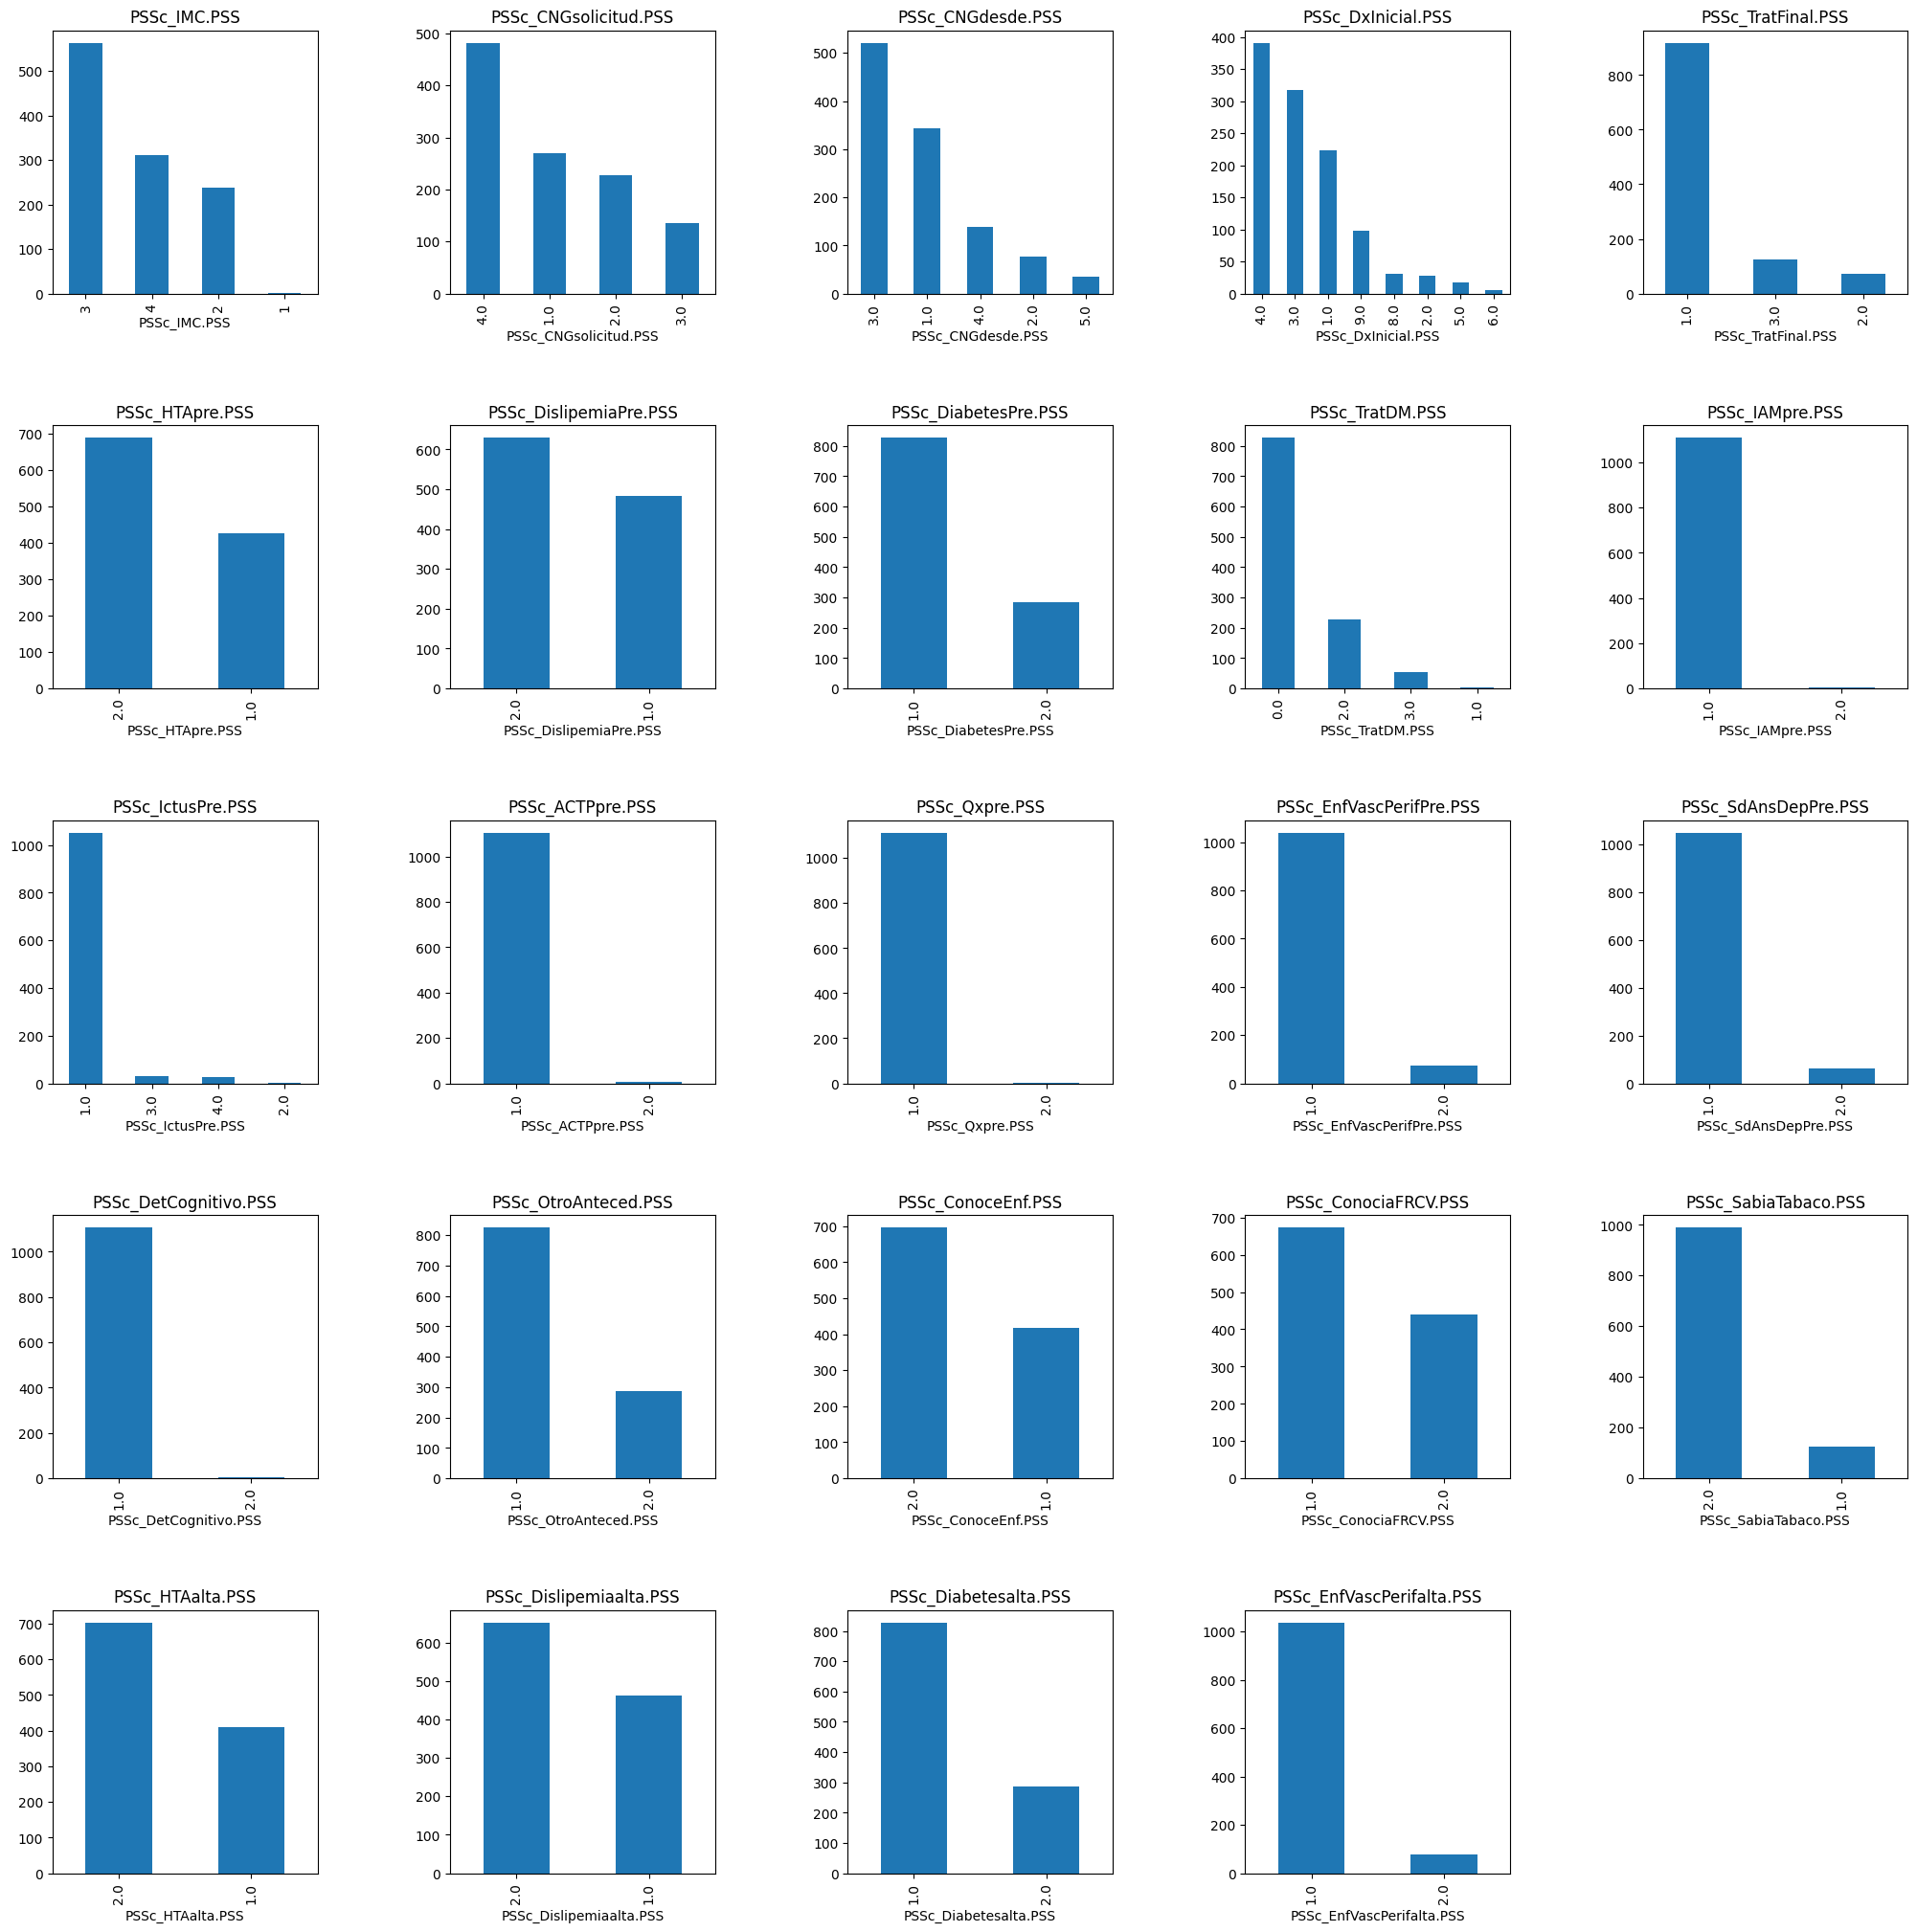

In [158]:
plot_variable_distributions(df_pss_clinical_nonulls, exclude_columns=['ID', 'MuerteCV', 'Revasc'])

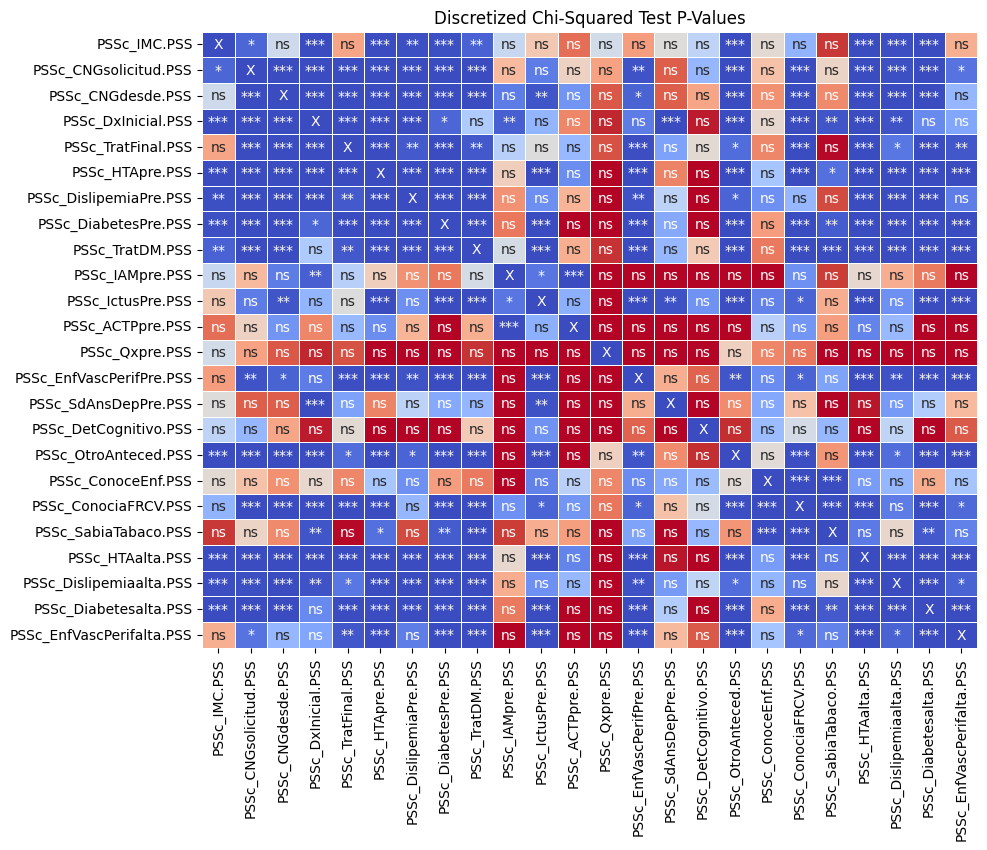

(                           ID  PSSc_IMC.PSS  PSSc_CNGsolicitud.PSS  \
 ID                        NaN           NaN                    NaN   
 PSSc_IMC.PSS              NaN  0.000000e+00           5.923872e-02   
 PSSc_CNGsolicitud.PSS     NaN  5.923872e-02           0.000000e+00   
 PSSc_CNGdesde.PSS         NaN  4.481765e-01          4.563020e-254   
 PSSc_DxInicial.PSS        NaN  1.842858e-05          1.698853e-136   
 PSSc_TratFinal.PSS        NaN  7.204621e-01           3.030750e-13   
 PSSc_HTApre.PSS           NaN  1.032497e-06           1.737725e-06   
 PSSc_DislipemiaPre.PSS    NaN  1.035674e-02           6.491042e-04   
 PSSc_DiabetesPre.PSS      NaN  8.177029e-03           1.086258e-05   
 PSSc_TratDM.PSS           NaN  4.903695e-02           3.291191e-04   
 PSSc_IAMpre.PSS           NaN  4.253218e-01           6.583728e-01   
 PSSc_IctusPre.PSS         NaN  6.123637e-01           1.102324e-01   
 PSSc_ACTPpre.PSS          NaN  8.449019e-01           5.720723e-01   
 PSSc_

In [159]:
# We analyze the correlation between the variables
analyze_correlations(df_pss_clinical_nonulls, ignore_vars=['ID', 'MuerteCV', 'Revasc'])

**PSS: HABITS AND CVD RISK FACTORS**

| Variable       | Original variable type        | Bin 1      | Bin 2      | Bin 3      | Bin 4      | Bin 5      | Bin 6      | Bin 7      | Bin 8      | Bin 9      |
|----------------|-------------------------------|------------|------------|------------|------------|------------|------------|------------|------------|------------|
| Fumador.PSS    | Nominal Categorical Variable  | 1 (Smoker) |2 (Ex-smoker)| 3 (Never smoked)       |            |            |            |            |            |
| DxInicial.PSS  | Nominal Categorical Variable  | 1          | 2 (5-10a)   | 3 (10-20a)| 4 (10-20a) | 5 (10-20a) | 6 (10-20a) |            |            |            |
| T.Exfumador.PSS| Nominal Categorical Variable  | 0          | 1          | 2          | 3          | 4          | 5          | 6          |            |            |
| T.tabaco.PSS   | Nominal Categorical Variable  | 0          | 1          | 2          | 3          | 4          | 5          | 6          |            |            |
| FumaFamilia.PSS| Nominal Categorical Variable  | 1 (No)     | 2 (Yes)    |            |            |            |            |            |            |            |
| NHijosfuman.PSS| Nominal Categorical Variable  | 1 (No)     | 2 (Yes)    |            |            |            |            |            |            |            |
|NHijosQueTiene.PSS| Nominal Categorical Variable| 1 (No)     | 2 (Yes)    |            |            |            |            |            |            |            |
| Alcohol.PSS    | Nominal Categorical Variable  |1 (Abstemio)|2 (FinDeSem)|3 (A diario)|            |            |            |            |            |            |
| Drogas.PSS     | Nominal Categorical Variable  |1 (Abstemio)|2 (FinDeSem)|3 (A diario)|            |            |            |            |            |            |
| SosoSalado.PSS | Nominal Categorical Variable  | 1 (No)     | 2 (Yes)    |            |            |            |            |            |            |            |
|AlimentVariada.PSS| Nominal Categorical Variable| 1 (No)     | 2 (Yes)    |            |            |            |            |            |            |            |
| Ejercicio.PSS  | Nominal Categorical Variable  | 1 (No)     | 2 (Yes)    |            |            |            |            |            |            |            |
|FrecEjercicio.PSS| Nominal Categorical Variable | 1          | 2          | 3          |            |            |            |            |            |            |
|SabeColesterol.PSS| Nominal Categorical Variable| 1 (No)     | 2 (Yes)    |            |            |            |            |            |            |            |

In [160]:
# We define a DataFrame with the PSS: Habits and CVD factors
df_pss_habits = df[['Id', 'Fumador.PSS', 'T.Exfumador.PSS', 'T.tabaco.PSS', 'CantTabaco.PSS', 'MotivoStopTabaco.PSS', 'IntencionDejar.PSS', 'PodraDejarlo.PSS', 'FumaFamilia.PSS', 'ParejaFuma.PSS', 'PadreFuma.PSS', 'MadreFuma.PSS', 'HijoFuma.PSS', 'NHijosfuman.PSS', 'NHijosQueTiene.PSS', 'OtrosFuma.PSS', 'Alcohol.PSS', 'Vino.PSS', 'Cerveza', 'Copas.PSS', 'Drogas.PSS', 'Marihuana.PSS', 'Cocaina.PSS', 'OtrosToxicos.PSS', 'SosoSalado.PSS', 'AlimentVariada.PSS', 'DietaTx.PSS', 'Ejercicio.PSS', 'Nadar.PSS', 'Correr.PSS', 'Bici.PSS', 'Gimnasio.PSS', 'OtroEjercicioTx', 'FrecEjercicio.PSS', 'IntensEjercicio.PSS', 'HaraMasEjercicio.PSS', 'CualMasEjercicio.PSS', 'SabeColesterol.PSS', 'FrecuenciaTA.PSS', 'QuienTA.PSS', 'Medidas prevencion HTA', 'PrevHTATx.PSS', 'FrecPeso.PSS', 'FrecMedico.PSS', 'Menopausia.PSS', 'Anticonceptivo.PSS']].rename(columns={'Id': 'ID', 'Fumador.PSS': 'PSSh_Fumador.PSS', 'T.Exfumador.PSS': 'PSSh_T.Exfumador.PSS', 'T.tabaco.PSS': 'PSSh_T.tabaco.PSS', 'CantTabaco.PSS': 'PSSh_CantTabaco.PSS', 'MotivoStopTabaco.PSS': 'PSSh_MotivoStopTabaco.PSS', 'IntencionDejar.PSS': 'PSSh_IntencionDejar.PSS', 'PodraDejarlo.PSS': 'PSSh_PodraDejarlo.PSS', 'FumaFamilia.PSS': 'PSSh_FumaFamilia.PSS', 'ParejaFuma.PSS': 'PSSh_ParejaFuma.PSS', 'PadreFuma.PSS': 'PSSh_PadreFuma.PSS', 'MadreFuma.PSS': 'PSSh_MadreFuma.PSS', 'HijoFuma.PSS': 'PSSh_HijoFuma.PSS', 'NHijosfuman.PSS': 'PSSh_NHijosfuman.PSS', 'NHijosQueTiene.PSS': 'PSSh_NHijosQueTiene.PSS', 'OtrosFuma.PSS': 'PSSh_OtrosFuma.PSS', 'Alcohol.PSS': 'PSSh_Alcohol.PSS', 'Vino.PSS': 'PSSh_Vino.PSS', 'Cerveza': 'PSSh_Cerveza', 'Copas.PSS': 'PSSh_Copas.PSS', 'Drogas.PSS': 'PSSh_Drogas.PSS', 'Marihuana.PSS': 'PSSh_Marihuana.PSS', 'Cocaina.PSS': 'PSSh_Cocaina.PSS', 'OtrosToxicos.PSS': 'PSSh_OtrosToxicos.PSS', 'SosoSalado.PSS': 'PSSh_SosoSalado.PSS', 'AlimentVariada.PSS': 'PSSh_AlimentVariada.PSS', 'DietaTx.PSS': 'PSSh_DietaTx.PSS', 'Ejercicio.PSS': 'PSSh_Ejercicio.PSS', 'Nadar.PSS': 'PSSh_Nadar.PSS', 'Correr.PSS': 'PSSh_Correr.PSS', 'Bici.PSS': 'PSSh_Bici.PSS', 'Gimnasio.PSS': 'PSSh_Gimnasio.PSS', 'OtroEjercicioTx': 'PSSh_OtroEjercicioTx', 'FrecEjercicio.PSS': 'PSSh_FrecEjercicio.PSS', 'IntensEjercicio.PSS': 'PSSh_IntensEjercicio.PSS', 'HaraMasEjercicio.PSS': 'PSSh_HaraMasEjercicio.PSS', 'CualMasEjercicio.PSS': 'PSSh_CualMasEjercicio.PSS', 'SabeColesterol.PSS': 'PSSh_SabeColesterol.PSS', 'FrecuenciaTA.PSS': 'PSSh_FrecuenciaTA.PSS', 'QuienTA.PSS': 'PSSh_QuienTA.PSS', 'Medidas prevencion HTA': 'PSSh_MedidasPrevencionHTA', 'PrevHTATx.PSS': 'PSSh_PrevHTATx.PSS', 'FrecPeso.PSS': 'PSSh_FrecPeso.PSS', 'FrecMedico.PSS': 'PSSh_FrecMedico.PSS', 'Menopausia.PSS': 'PSSh_Menopausia.PSS', 'Anticonceptivo.PSS': 'PSSh_Anticonceptivo.PSS'})

# We also add the columns "Muerte CV" and "Revasc" to the DataFrame
df_pss_habits.loc[:, 'MuerteCV'] = df['Muerte CV']
df_pss_habits.loc[:, 'Revasc'] = df['Revasc']

# We remove the column CantTabaco.PSS
df_pss_habits.drop('PSSh_CantTabaco.PSS', axis=1, inplace=True)

# We remove the column MotivoStopTabaco.PSS
df_pss_habits.drop('PSSh_MotivoStopTabaco.PSS', axis=1, inplace=True)

# We remove the column IntencionDejar.PSS
df_pss_habits.drop('PSSh_IntencionDejar.PSS', axis=1, inplace=True)

# We remove the column PodraDejarlo.PSS
df_pss_habits.drop('PSSh_PodraDejarlo.PSS', axis=1, inplace=True)

# We remove the column ParejaFuma.PSS
df_pss_habits.drop('PSSh_ParejaFuma.PSS', axis=1, inplace=True)

# We remove the column PadreFuma.PSS
df_pss_habits.drop('PSSh_PadreFuma.PSS', axis=1, inplace=True)

# We remove the column MadreFuma.PSS
df_pss_habits.drop('PSSh_MadreFuma.PSS', axis=1, inplace=True)

# We remove the column HijoFuma.PSS
df_pss_habits.drop('PSSh_HijoFuma.PSS', axis=1, inplace=True)

# We remove the column OtrosFuma.PSS
df_pss_habits.drop('PSSh_OtrosFuma.PSS', axis=1, inplace=True)

# We remove the column Vino.PSS
df_pss_habits.drop('PSSh_Vino.PSS', axis=1, inplace=True)

# We remove the column Cerveza
df_pss_habits.drop('PSSh_Cerveza', axis=1, inplace=True)

# We remove the column Copas.PSS
df_pss_habits.drop('PSSh_Copas.PSS', axis=1, inplace=True)

# We remove the column Marihuana.PSS
df_pss_habits.drop('PSSh_Marihuana.PSS', axis=1, inplace=True)

# We remove the column Cocaina.PSS
df_pss_habits.drop('PSSh_Cocaina.PSS', axis=1, inplace=True)

# We remove the column OtrosToxicos.PSS
df_pss_habits.drop('PSSh_OtrosToxicos.PSS', axis=1, inplace=True)

# We remove the column Dietatx.PSS
df_pss_habits.drop('PSSh_DietaTx.PSS', axis=1, inplace=True)

# We remove the column Nadar.PSS
df_pss_habits.drop('PSSh_Nadar.PSS', axis=1, inplace=True)

# We remove the column Correr.PSS
df_pss_habits.drop('PSSh_Correr.PSS', axis=1, inplace=True)

# We remove the column Bici.PSS
df_pss_habits.drop('PSSh_Bici.PSS', axis=1, inplace=True)

# We remove the column Gimnasio.PSS
df_pss_habits.drop('PSSh_Gimnasio.PSS', axis=1, inplace=True)

# We remove the column OtroEjercicioTx
df_pss_habits.drop('PSSh_OtroEjercicioTx', axis=1, inplace=True)

# We remove the column IntensEjercicio.PSS
df_pss_habits.drop('PSSh_IntensEjercicio.PSS', axis=1, inplace=True)

# We remove the column HaraMasEjercicio.PSS
df_pss_habits.drop('PSSh_HaraMasEjercicio.PSS', axis=1, inplace=True)

# We remove the column CualMasEjercicio.PSS
df_pss_habits.drop('PSSh_CualMasEjercicio.PSS', axis=1, inplace=True)

# We remove the column SabeColesterol.PSS
df_pss_habits.drop('PSSh_SabeColesterol.PSS', axis=1, inplace=True)

# We remove the column FrecuenciaTA.PSS
df_pss_habits.drop('PSSh_FrecuenciaTA.PSS', axis=1, inplace=True)

# We remove the column QuienTA.PSS
df_pss_habits.drop('PSSh_QuienTA.PSS', axis=1, inplace=True)

# We remove the column Medidas prevencion HTA
df_pss_habits.drop('PSSh_MedidasPrevencionHTA', axis=1, inplace=True)

# We remove the column PrevHTATx.PSS
df_pss_habits.drop('PSSh_PrevHTATx.PSS', axis=1, inplace=True)

# We remove the column FrecPeso.PSS
df_pss_habits.drop('PSSh_FrecPeso.PSS', axis=1, inplace=True)

# We remove the column FrecMedico.PSS
df_pss_habits.drop('PSSh_FrecMedico.PSS', axis=1, inplace=True)

# We remove the column Menopausia.PSS
df_pss_habits.drop('PSSh_Menopausia.PSS', axis=1, inplace=True)

# We remove the column Anticonceptivo.PSS
df_pss_habits.drop('PSSh_Anticonceptivo.PSS', axis=1, inplace=True)

# We set a 0 in T.Exfumador.PSS for the values where Fumador.PSS takes the values 1 and 3
df_pss_habits.loc[df_pss_habits['PSSh_Fumador.PSS'].isin([1, 3]), 'PSSh_T.Exfumador.PSS'] = 0

# We set a 0 in T.tabaco.PSS for the values where Fumador.PSS takes the value 3
df_pss_habits.loc[df_pss_habits['PSSh_Fumador.PSS'] == 3, 'PSSh_T.tabaco.PSS'] = 0

# We remove the column NHijosfuman.PSS
df_pss_habits.drop('PSSh_NHijosfuman.PSS', axis=1, inplace=True)

# We remove the column NHijosQueTiene.PSS
df_pss_habits.drop('PSSh_NHijosQueTiene.PSS', axis=1, inplace=True)

# We remove the columns that exceed 25% of null values
df_pss_habits = remove_columns_nulls(df_pss_habits, 0.25)

# We delete the rows that contain null values
df_pss_habits_nonulls, n_rows = remove_rows_nulls(df_pss_habits)
print("Number of records with missing values:", n_rows)

count_variables_records(df_pss_habits_nonulls)

df_pss_habits.to_csv('pss_habits.csv', index=False)
df_pss_habits_nonulls.to_csv('pss_habits_nonulls.csv', index=False)

# We print the unique values of the columns
for i in df_pss_habits_nonulls.columns:
    print(i, df_pss_habits_nonulls[i].unique())


Number of records with missing values: 1311
Number of variables: 13
Number of records: 1167
ID [   2    4    5 ... 2473 2474 2476]
PSSh_Fumador.PSS [3. 2. 1.]
PSSh_T.Exfumador.PSS [0. 4. 3. 1. 5. 2. 6.]
PSSh_T.tabaco.PSS [0. 4. 6. 3. 5. 2. 1.]
PSSh_FumaFamilia.PSS [2. 1.]
PSSh_Alcohol.PSS [1. 3. 2.]
PSSh_Drogas.PSS [1. 3. 2.]
PSSh_SosoSalado.PSS [1. 2.]
PSSh_AlimentVariada.PSS [2. 1.]
PSSh_Ejercicio.PSS [2. 1.]
PSSh_FrecEjercicio.PSS [1. 3. 2.]
MuerteCV [0. 1.]
Revasc [0. 1. 5.]


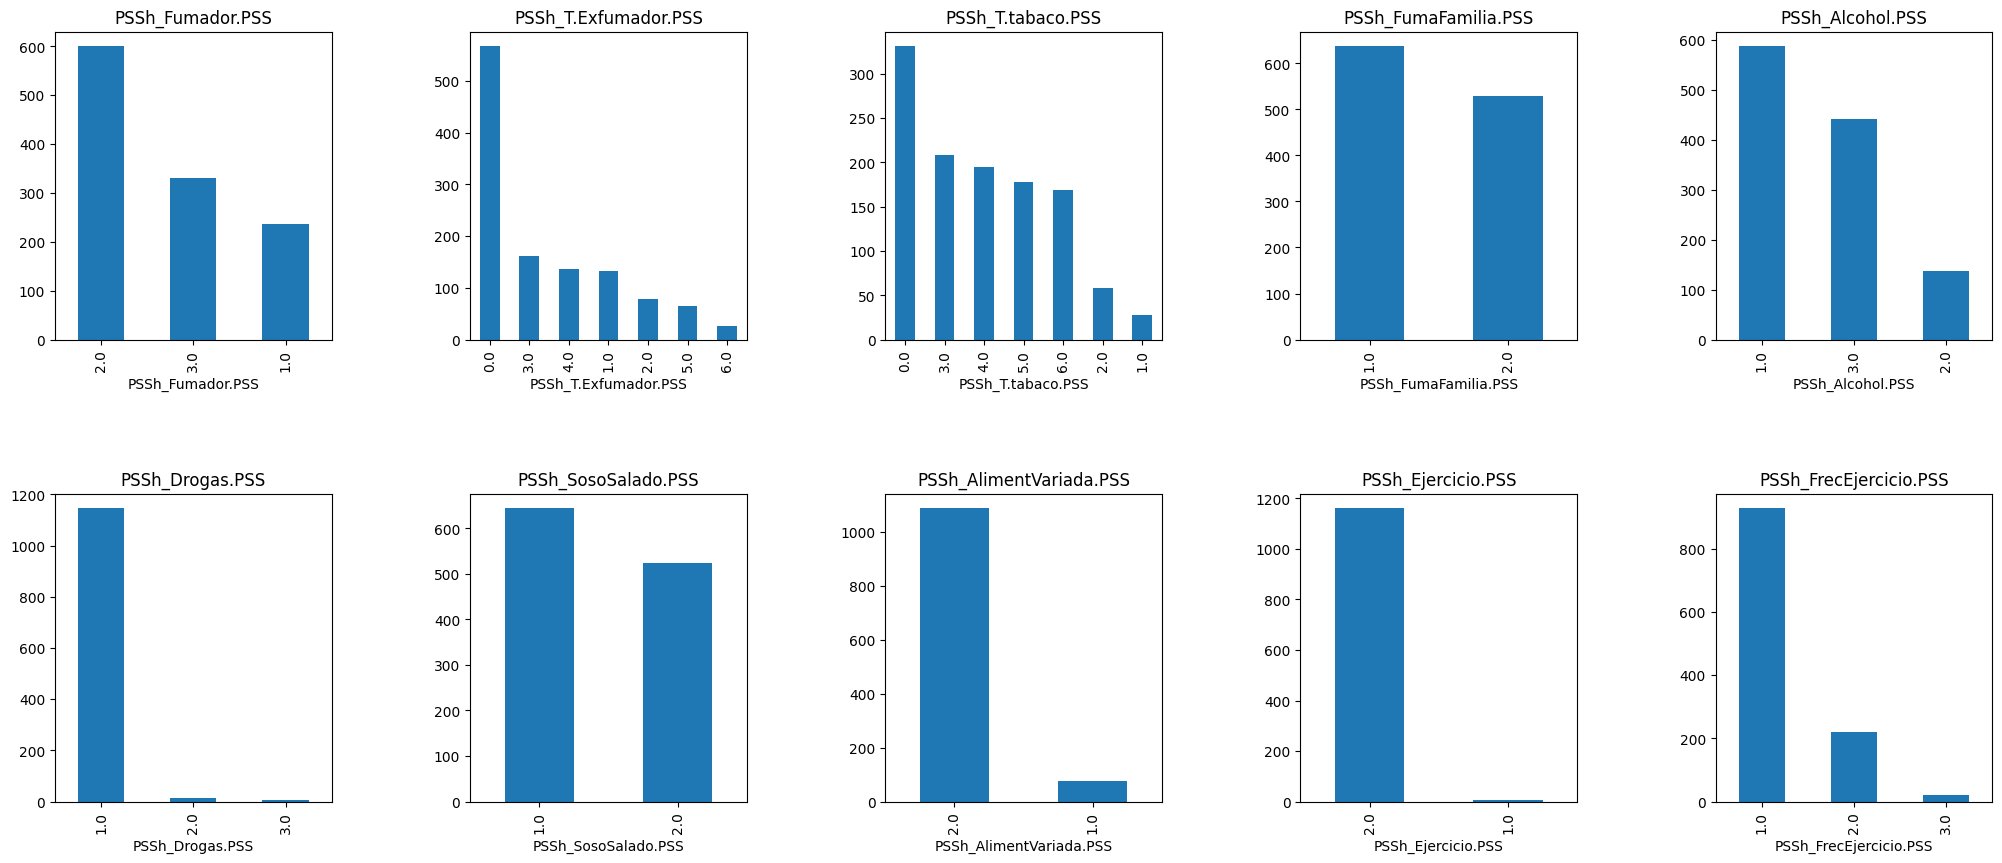

In [161]:
plot_variable_distributions(df_pss_habits_nonulls, exclude_columns=['ID', 'MuerteCV', 'Revasc'])

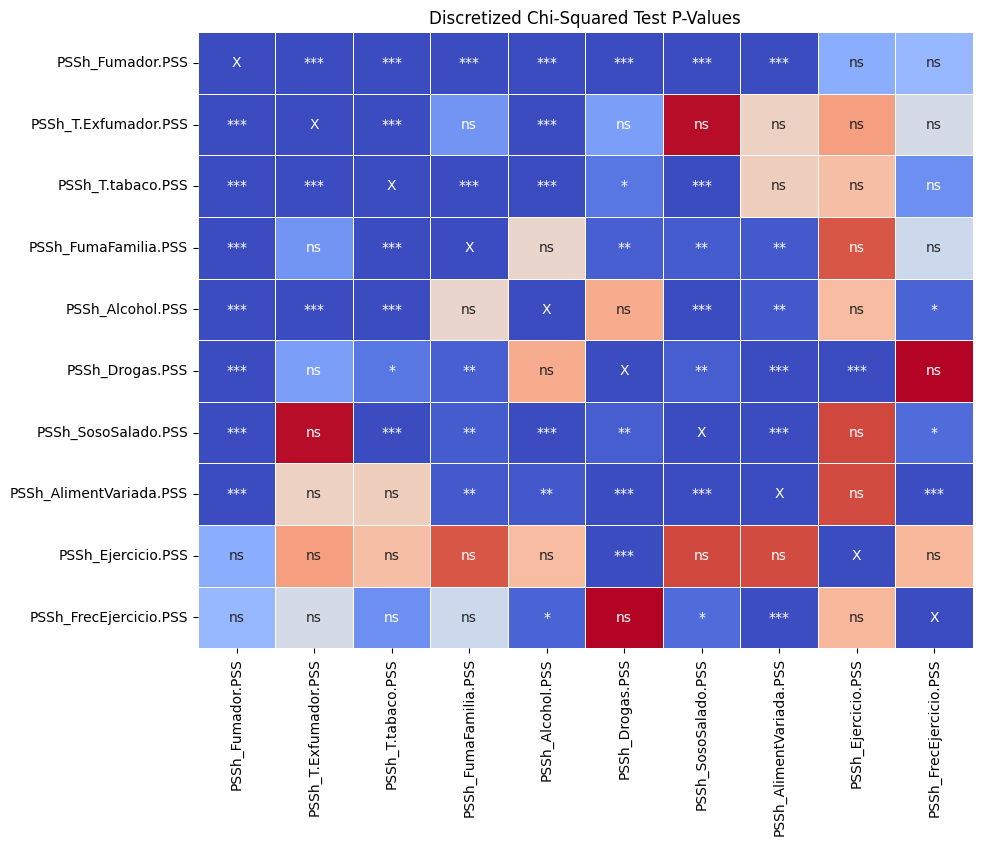

(                         ID  PSSh_Fumador.PSS  PSSh_T.Exfumador.PSS  \
 ID                      NaN               NaN                   NaN   
 PSSh_Fumador.PSS        NaN      0.000000e+00         2.207618e-242   
 PSSh_T.Exfumador.PSS    NaN     2.207618e-242          0.000000e+00   
 PSSh_T.tabaco.PSS       NaN     1.799367e-267         8.076645e-140   
 PSSh_FumaFamilia.PSS    NaN      1.574966e-08          1.651637e-01   
 PSSh_Alcohol.PSS        NaN      3.092715e-05          1.460249e-04   
 PSSh_Drogas.PSS         NaN      4.072143e-08          1.935649e-01   
 PSSh_SosoSalado.PSS     NaN      7.266522e-10          9.434149e-01   
 PSSh_AlimentVariada.PSS NaN      4.671800e-04          5.450379e-01   
 PSSh_Ejercicio.PSS      NaN      2.317338e-01          7.042641e-01   
 PSSh_FrecEjercicio.PSS  NaN      2.652977e-01          4.459217e-01   
 MuerteCV                NaN               NaN                   NaN   
 Revasc                  NaN               NaN                  

In [162]:
# We analyze the correlation between the variables
analyze_correlations(df_pss_habits_nonulls, ignore_vars=['ID', 'MuerteCV', 'Revasc'])

**PSS: SELF-CARE**

| Variable       | Original variable type        | Bin 1      | Bin 2      | Bin 3      | Bin 4      | Bin 5      | Bin 6      | Bin 7      | Bin 8      | Bin 9      |            |            |
|----------------|-------------------------------|------------|------------|------------|------------|------------|------------|------------|------------|------------|------------|------------|
|Autopercepcion.PSS| Nominal Categorical Variable| 0          | 1          | 2          | 3          | 4          | 5          | 6          | 7          | 8          | 9          | 10         |
|OlvidaConsult.PSS| Nominal Categorical Variable | 1 (No)     | 2 (Yes)    |            |            |            |            |            |            |            |            |            |
| SabeTrat.PSS   | Nominal Categorical Variable  | 1 (No)     | 2 (Yes)    |            |            |            |            |            |            |            |            |            |
|ControlMedicac.PSS| Nominal Categorical Variable| 1 (No)     | 2 (Yes)    |            |            |            |            |            |            |            |            |            |
|FrecOlvidoTrat.PSS| Nominal Categorical Variable| 0          | 1          | 2          | 3          | 4          |            |            |            |            |            |            |
| SaludTV.PSS    | Nominal Categorical Variable  | 1 (No)     | 2 (Yes)    |            |            |            |            |            |            |            |            |            |
|FamiliaEnferma.PSS| Nominal Categorical Variable| 1 (No)     | 2 (Yes)    |            |            |            |            |            |            |            |            |            |
| ConsultaKT.PSS | Nominal Categorical Variable  | 1 (No)     | 2 (Yes)    |            |            |            |            |            |            |            |            |            |
|FamiliaConsultaKT.PSS|Nominal Categorical Variable| 0 (No)   | 1 (Yes)    |            |            |            |            |            |            |            |            |            |
|InternetConsultaKT.PSS|Nominal Categorical Variable| 0 (No)  | 1 (Yes)    |            |            |            |            |            |            |            |            |            |
|Profesionales.KT.PSS|Nominal Categorical Variable| 0 (No)    | 1 (Yes)    |            |            |            |            |            |            |            |            |            |
|Profesionales.PSS|Nominal Categorical Variable  | 0 (No)     | 1 (Yes)    |            |            |            |            |            |            |            |            |            |
|Internet.PSS    |Nominal Categorical Variable   | 0 (No)     | 1 (Yes)    |            |            |            |            |            |            |            |            |            |
|OtrosConsultEnf.PSS|Nominal Categorical Variable| 0 (No)     | 1 (Yes)    |            |            |            |            |            |            |            |            |            |

In [163]:
# We define a DataFrame with the PSS: Self-care
df_pss_sc = df[['Id', 'Autopercepcion.PSS', 'OlvidaConsult.PSS', 'SabeTrat.PSS', 'ControlMedicac.PSS', 'FrecOlvidoTrat.PSS', 'SaludTV.PSS', 'FamiliaEnferma.PSS', 'FamiliaresConEnfTx', 'ConsultaKT.PSS', 'FamiliaConsultaKT.PSS', 'InternetConsultaKT.PSS', 'Profesionales.KT.PSS', 'ConsultaEnferm.PSS', 'Profesionales.PSS', 'Internet.PSS', 'OtrosConsultEnf.PSS', 'SabeactuarAngina.PSS', 'ActAnginaTx.PSS']].rename(columns={'Id': 'ID', 'Autopercepcion.PSS': 'PSSs_Autopercepcion.PSS', 'OlvidaConsult.PSS': 'PSSs_OlvidaConsult.PSS', 'SabeTrat.PSS': 'PSSs_SabeTrat.PSS', 'ControlMedicac.PSS': 'PSSs_ControlMedicac.PSS', 'FrecOlvidoTrat.PSS': 'PSSs_FrecOlvidoTrat.PSS', 'SaludTV.PSS': 'PSSs_SaludTV.PSS', 'FamiliaEnferma.PSS': 'PSSs_FamiliaEnferma.PSS', 'FamiliaresConEnfTx': 'PSSs_FamiliaresConEnfTx', 'ConsultaKT.PSS': 'PSSs_ConsultaKT.PSS', 'FamiliaConsultaKT.PSS': 'PSSs_FamiliaConsultaKT.PSS', 'InternetConsultaKT.PSS': 'PSSs_InternetConsultaKT.PSS', 'Profesionales.KT.PSS': 'PSSs_Profesionales.KT.PSS', 'ConsultaEnferm.PSS': 'PSSs_ConsultaEnferm.PSS', 'Profesionales.PSS': 'PSSs_Profesionales.PSS', 'Internet.PSS': 'PSSs_Internet.PSS', 'OtrosConsultEnf.PSS': 'PSSs_OtrosConsultEnf.PSS', 'SabeactuarAngina.PSS': 'PSSs_SabeactuarAngina.PSS', 'ActAnginaTx.PSS': 'PSSs_ActAnginaTx.PSS'})

# We also add the columns "Muerte CV" and "Revasc" to the DataFrame
df_pss_sc.loc[:, 'MuerteCV'] = df['Muerte CV']
df_pss_sc.loc[:, 'Revasc'] = df['Revasc']

# We delete the column FamiliaresConEnfTx
df_pss_sc.drop('PSSs_FamiliaresConEnfTx', axis=1, inplace=True)

# We delete the column ConsultaEnferm.PSS
df_pss_sc.drop('PSSs_ConsultaEnferm.PSS', axis=1, inplace=True)

# We delete the column SabeactuarAngina.PSS
df_pss_sc.drop('PSSs_SabeactuarAngina.PSS', axis=1, inplace=True)

# We delete the column ActAnginaTx.PSS
df_pss_sc.drop('PSSs_ActAnginaTx.PSS', axis=1, inplace=True)

# We remove the columns that exceed 25% of null values
df_pss_sc = remove_columns_nulls(df_pss_sc, 0.25)

# We delete the rows that contain null values
df_pss_sc_nonulls, n_rows = remove_rows_nulls(df_pss_sc)
print("Number of records with missing values:", n_rows)

count_variables_records(df_pss_sc_nonulls)

df_pss_sc.to_csv('pss_selfcare.csv', index=False)
df_pss_sc_nonulls.to_csv('pss_selfcare_nonulls.csv', index=False)

# We print the unique values of the columns
for i in df_pss_sc_nonulls.columns:
    print(i, df_pss_sc_nonulls[i].unique())

Number of records with missing values: 963
Number of variables: 17
Number of records: 1515
ID [   1    2    4 ... 2476 2477 2478]
PSSs_Autopercepcion.PSS [ 6. 10.  8.  4.  9.  7.  5.  3.  1.  2.]
PSSs_OlvidaConsult.PSS [1. 2.]
PSSs_SabeTrat.PSS [2. 1.]
PSSs_ControlMedicac.PSS [1. 2. 3.]
PSSs_FrecOlvidoTrat.PSS [4. 3. 2. 1.]
PSSs_SaludTV.PSS [1. 2.]
PSSs_FamiliaEnferma.PSS [1. 2.]
PSSs_ConsultaKT.PSS [1. 2.]
PSSs_FamiliaConsultaKT.PSS [0 1]
PSSs_InternetConsultaKT.PSS [0 1]
PSSs_Profesionales.KT.PSS [0 1]
PSSs_Profesionales.PSS [0 1]
PSSs_Internet.PSS [0 1]
PSSs_OtrosConsultEnf.PSS [0 1]
MuerteCV [0. 1.]
Revasc [1. 0. 5.]


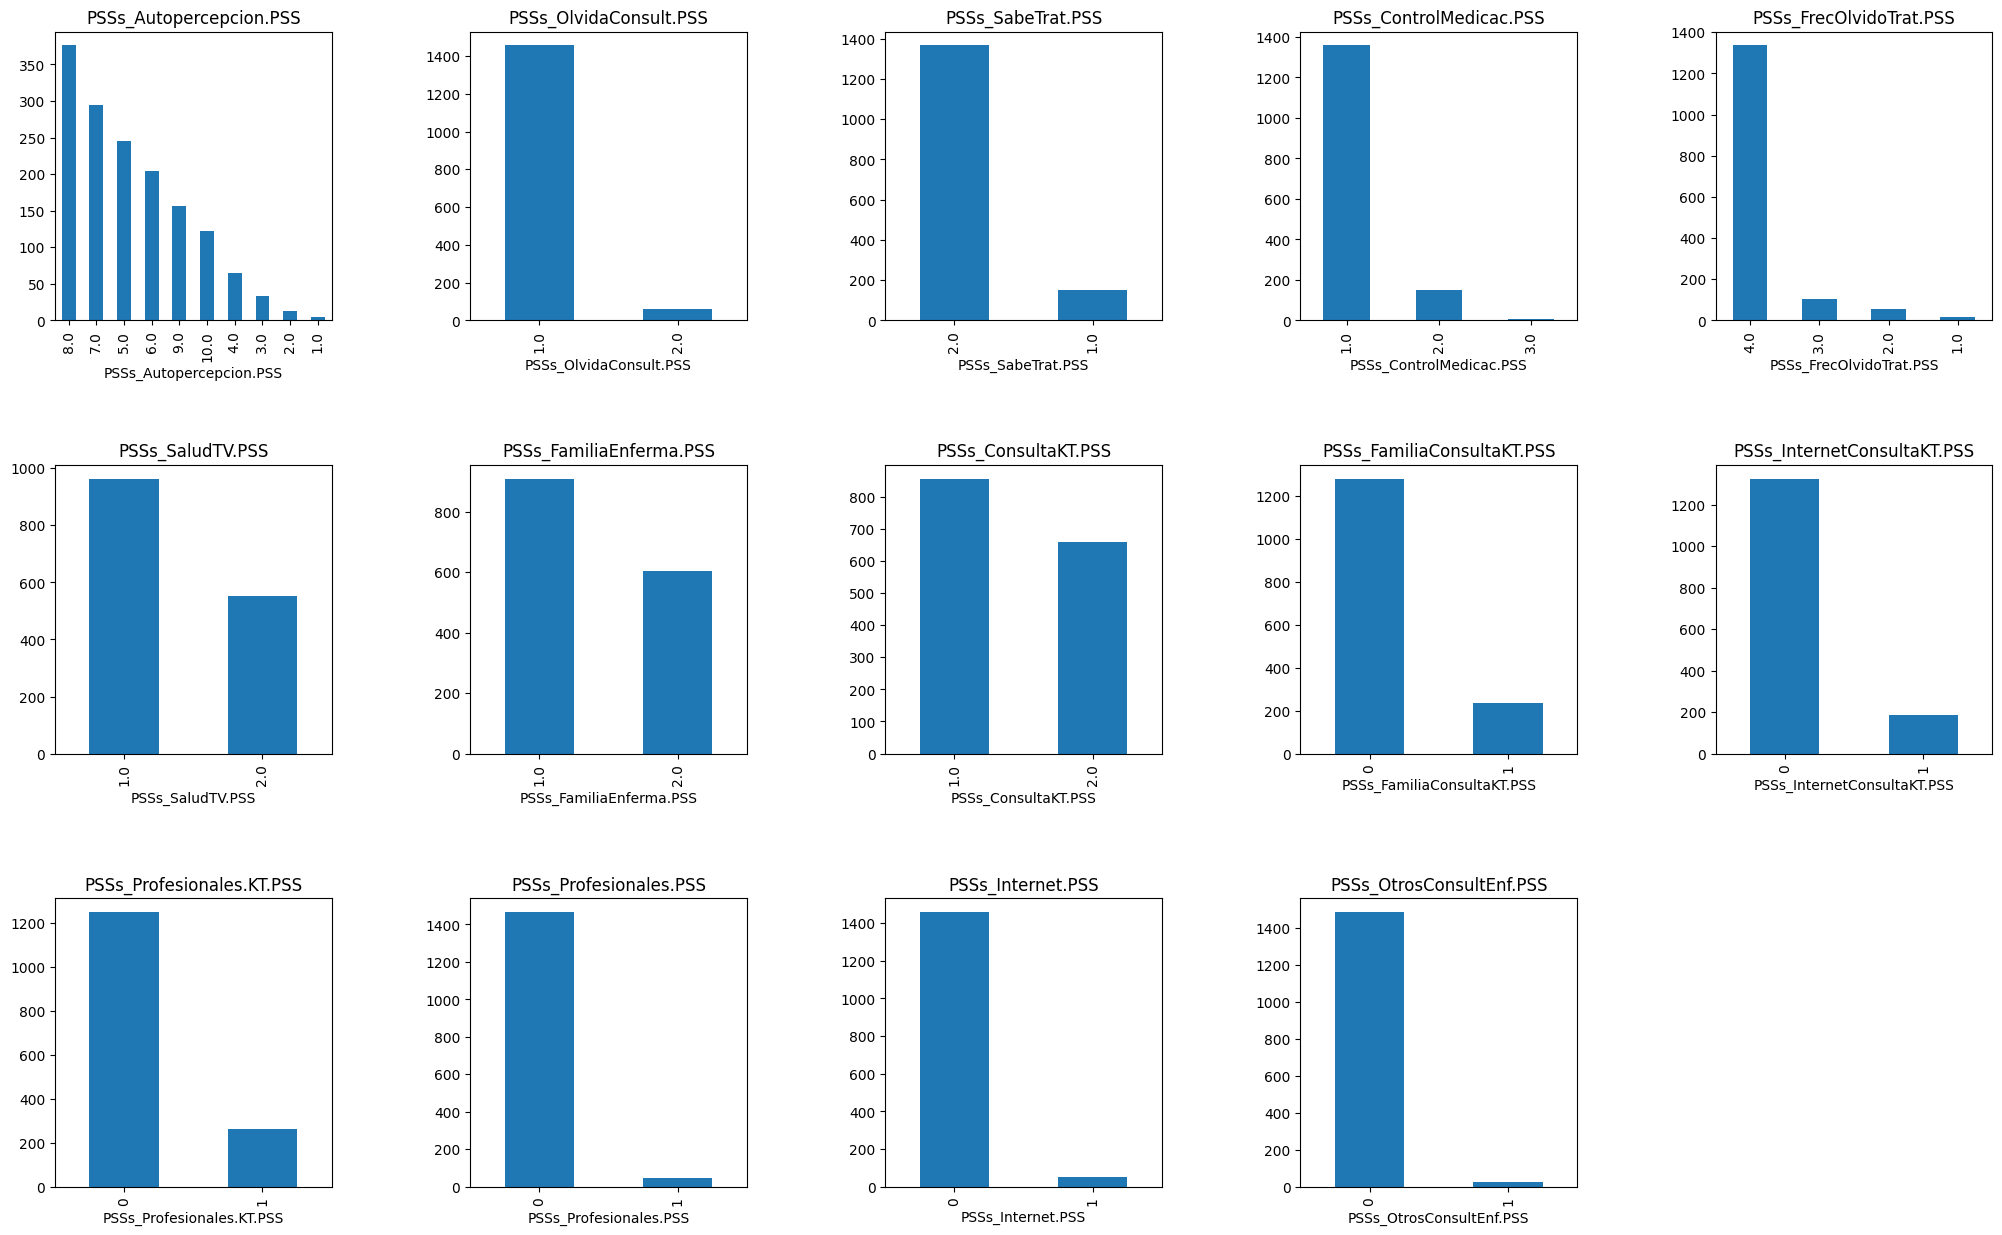

In [164]:
plot_variable_distributions(df_pss_sc_nonulls, exclude_columns=['ID', 'MuerteCV', 'Revasc'])

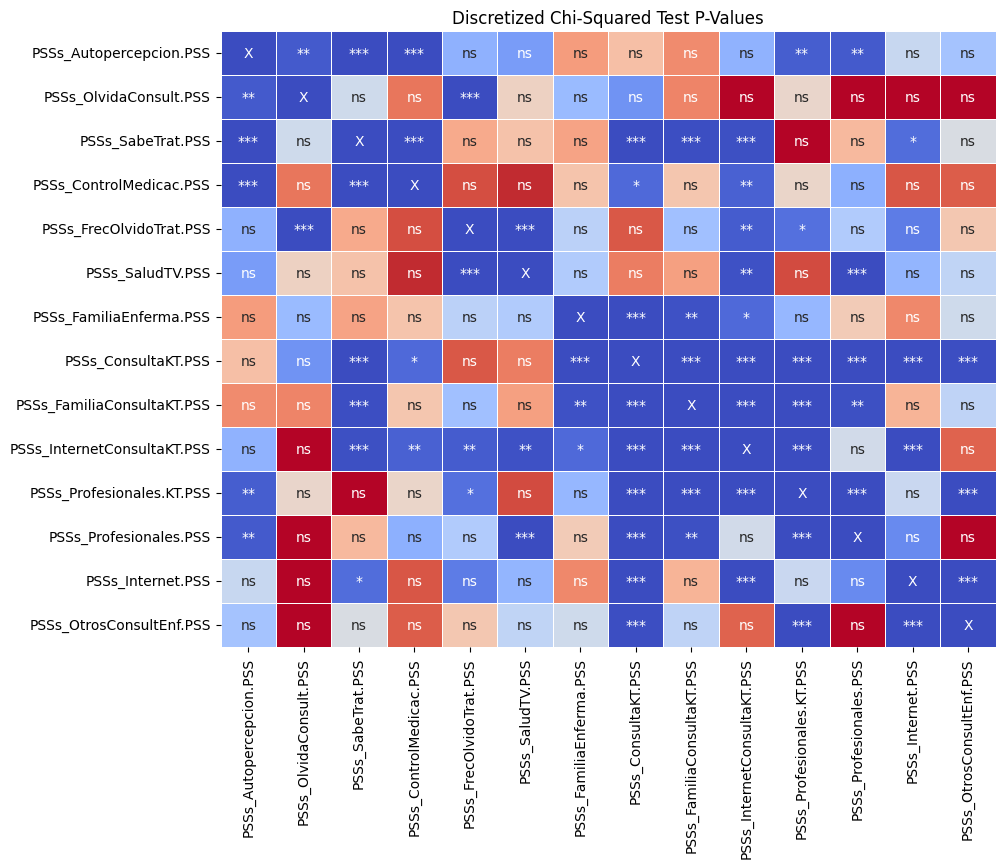

(                             ID  PSSs_Autopercepcion.PSS  \
 ID                          NaN                      NaN   
 PSSs_Autopercepcion.PSS     NaN                 0.000000   
 PSSs_OlvidaConsult.PSS      NaN                 0.033197   
 PSSs_SabeTrat.PSS           NaN                 0.001993   
 PSSs_ControlMedicac.PSS     NaN                 0.000507   
 PSSs_FrecOlvidoTrat.PSS     NaN                 0.256024   
 PSSs_SaludTV.PSS            NaN                 0.191715   
 PSSs_FamiliaEnferma.PSS     NaN                 0.743777   
 PSSs_ConsultaKT.PSS         NaN                 0.641766   
 PSSs_FamiliaConsultaKT.PSS  NaN                 0.785030   
 PSSs_InternetConsultaKT.PSS NaN                 0.259210   
 PSSs_Profesionales.KT.PSS   NaN                 0.041892   
 PSSs_Profesionales.PSS      NaN                 0.032814   
 PSSs_Internet.PSS           NaN                 0.424663   
 PSSs_OtrosConsultEnf.PSS    NaN                 0.319137   
 MuerteCV               

In [165]:
# We analyze the correlation between the variables
analyze_correlations(df_pss_sc_nonulls, ignore_vars=['ID', 'MuerteCV', 'Revasc'])

**PSS: SOCIAL**

In [166]:
# We define a DataFrame with the PSS: Social
df_pss_soc = df[['Id', 'NivelEstudios.PSS', 'TipoTrabajo.PSS', 'Ocupacion.PSS', 'EstadoCivil', 'LugarResidencia.PSS', 'ConQuienVive.PSS', 'ApoyoFamiliar', 'TareasHogar.PSS', 'NHijos.PSS', 'NNietos.PSS', '¿Tiene mascota?', 'MascotasTx.PSS', 'Familia.Aficc.PSS', 'TV.Aficc.PSS', 'Amigos.Aficc.PSS', 'Musica.Aficc.PSS', 'Lectura.Aficc.PSS', 'Radio.Aficc.PSS', 'Compras.Aficc.PSS', 'Cine.Aficc.PSS', 'Campo.Aficc.PSS', 'VerDeportes.Aficc.PSS', 'Bailar.Aficc.PSS', 'Cultura.Aficc.PSS', 'SalirComer.Aficc.PSS', 'Pub.Aficc.PSS', 'Otros.Aficc.PSS', 'Autobus.PSS', 'Taxi.PSS', 'Coche.PSS', 'Moto.PSS', 'Bici.PSS', 'Caminando.PSS', 'OtrosVehiculos.PSS', 'Facebook.PSS', 'Twitter.PSS', 'Youtube.PSS', 'LinkeDin.PSS', 'Spotify.PSS', 'OtrasRedes.PSS', 'TelefMovil.PSS', 'APPs.PSS', 'Internet.PSS', 'Tablet.PSS', 'Ordenador.PSS', 'Portatil.PSS', 'SmartTV.PSS', 'Wifi.Publica.PSS', 'ConoceSkype.PSS', 'UsaSkype']].rename(columns={'Id': 'ID', 'NivelEstudios.PSS': 'PSSso_NivelEstudios.PSS', 'TipoTrabajo.PSS': 'PSSso_TipoTrabajo.PSS', 'Ocupacion.PSS': 'PSSso_Ocupacion.PSS', 'EstadoCivil': 'PSSso_EstadoCivil', 'LugarResidencia.PSS': 'PSSso_LugarResidencia.PSS', 'ConQuienVive.PSS': 'PSSso_ConQuienVive.PSS', 'ApoyoFamiliar': 'PSSso_ApoyoFamiliar', 'TareasHogar.PSS': 'PSSso_TareasHogar.PSS', 'NHijos.PSS': 'PSSso_NHijos.PSS', 'NNietos.PSS': 'PSSso_NNietos.PSS', '¿Tiene mascota?': 'PSSso_TieneMascota', 'MascotasTx.PSS': 'PSSso_MascotasTx.PSS', 'Familia.Aficc.PSS': 'PSSso_Familia.Aficc.PSS', 'TV.Aficc.PSS': 'PSSso_TV.Aficc.PSS', 'Amigos.Aficc.PSS': 'PSSso_Amigos.Aficc.PSS', 'Musica.Aficc.PSS': 'PSSso_Musica.Aficc.PSS', 'Lectura.Aficc.PSS': 'PSSso_Lectura.Aficc.PSS', 'Radio.Aficc.PSS': 'PSSso_Radio.Aficc.PSS', 'Compras.Aficc.PSS': 'PSSso_Compras.Aficc.PSS', 'Cine.Aficc.PSS': 'PSSso_Cine.Aficc.PSS', 'Campo.Aficc.PSS': 'PSSso_Campo.Aficc.PSS', 'VerDeportes.Aficc.PSS': 'PSSso_VerDeportes.Aficc.PSS', 'Bailar.Aficc.PSS': 'PSSso_Bailar.Aficc.PSS', 'Cultura.Aficc.PSS': 'PSSso_Cultura.Aficc.PSS', 'SalirComer.Aficc.PSS': 'PSSso_SalirComer.Aficc.PSS', 'Pub.Aficc.PSS': 'PSSso_Pub.Aficc.PSS', 'Otros.Aficc.PSS': 'PSSso_Otros.Aficc.PSS', 'Autobus.PSS': 'PSSso_Autobus.PSS', 'Taxi.PSS': 'PSSso_Taxi.PSS', 'Coche.PSS': 'PSSso_Coche.PSS', 'Moto.PSS': 'PSSso_Moto.PSS', 'Bici.PSS': 'PSSso_Bici.PSS', 'Caminando.PSS': 'PSSso_Caminando.PSS', 'OtrosVehiculos.PSS': 'PSSso_OtrosVehiculos.PSS', 'Facebook.PSS': 'PSSso_Facebook.PSS', 'Twitter.PSS': 'PSSso_Twitter.PSS', 'Youtube.PSS': 'PSSso_Youtube.PSS', 'LinkeDin.PSS': 'PSSso_LinkeDin.PSS', 'Spotify.PSS': 'PSSso_Spotify.PSS', 'OtrasRedes.PSS': 'PSSso_OtrasRedes.PSS', 'TelefMovil.PSS': 'PSSso_TelefMovil.PSS', 'APPs.PSS': 'PSSso_APPs.PSS', 'Internet.PSS': 'PSSso_Internet.PSS', 'Tablet.PSS': 'PSSso_Tablet.PSS', 'Ordenador.PSS': 'PSSso_Ordenador.PSS', 'Portatil.PSS': 'PSSso_Portatil.PSS', 'SmartTV.PSS': 'PSSso_SmartTV.PSS', 'Wifi.Publica.PSS': 'PSSso_Wifi.Publica.PSS', 'ConoceSkype.PSS': 'PSSso_ConoceSkype.PSS', 'UsaSkype': 'PSSso_UsaSkype'})

# We also add the columns "Muerte CV" and "Revasc" to the DataFrame
df_pss_soc.loc[:, 'MuerteCV'] = df['Muerte CV']
df_pss_soc.loc[:, 'Revasc'] = df['Revasc']

# We remove the column MascotasTx.PSS
df_pss_soc.drop('PSSso_MascotasTx.PSS', axis=1, inplace=True)

# We remove the column Otros.Aficc.PSS
df_pss_soc.drop('PSSso_Otros.Aficc.PSS', axis=1, inplace=True)

# We remove the column OtrosVehiculos.PSS
df_pss_soc.drop('PSSso_OtrosVehiculos.PSS', axis=1, inplace=True)

# We remove the column OtrasRedes.PSS
df_pss_soc.drop('PSSso_OtrasRedes.PSS', axis=1, inplace=True)

# We remove the columns that exceed 25% of null values
df_pss_soc = remove_columns_nulls(df_pss_soc, 0.25)

# We delete the rows that contain null values
df_pss_soc_nonulls, n_rows = remove_rows_nulls(df_pss_soc)
print("Number of records with missing values:", n_rows)

count_variables_records(df_pss_soc_nonulls)

df_pss_soc.to_csv('pss_social.csv', index=False)
df_pss_soc_nonulls.to_csv('pss_social_nonulls.csv', index=False)

# We print the unique values of the columns
for i in df_pss_soc_nonulls.columns:
    print(i, df_pss_soc_nonulls[i].unique())

Number of records with missing values: 754
Number of variables: 49
Number of records: 1724
ID [   1    2    4 ... 2476 2477 2478]
PSSso_NivelEstudios.PSS [3. 2. 4. 1.]
PSSso_TipoTrabajo.PSS [2. 1.]
PSSso_Ocupacion.PSS [2. 4. 3.]
PSSso_EstadoCivil [2. 4. 3. 1.]
PSSso_LugarResidencia.PSS [1. 2.]
PSSso_ConQuienVive.PSS [2. 1. 4. 3.]
PSSso_ApoyoFamiliar [2. 1.]
PSSso_TareasHogar.PSS [2. 1. 3.]
PSSso_NHijos.PSS [ 2.  4.  3.  0.  1.  5.  6.  8.  7. 10.]
PSSso_NNietos.PSS [ 0.  3.  5.  4. 10.  2.  1.  8.  7. 17.  6.  9. 11. 14. 12. 13. 29. 15.]
PSSso_TieneMascota [2 1]
PSSso_Familia.Aficc.PSS [1 0]
PSSso_TV.Aficc.PSS [1 0]
PSSso_Amigos.Aficc.PSS [1 0]
PSSso_Musica.Aficc.PSS [1 0]
PSSso_Lectura.Aficc.PSS [0 1]
PSSso_Radio.Aficc.PSS [1 0]
PSSso_Compras.Aficc.PSS [1 0]
PSSso_Cine.Aficc.PSS [0 1]
PSSso_Campo.Aficc.PSS [1 0]
PSSso_VerDeportes.Aficc.PSS [1 0]
PSSso_Bailar.Aficc.PSS [0 1]
PSSso_Cultura.Aficc.PSS [1 0]
PSSso_SalirComer.Aficc.PSS [1 0]
PSSso_Pub.Aficc.PSS [0. 1.]
PSSso_Autobus.PSS [0 

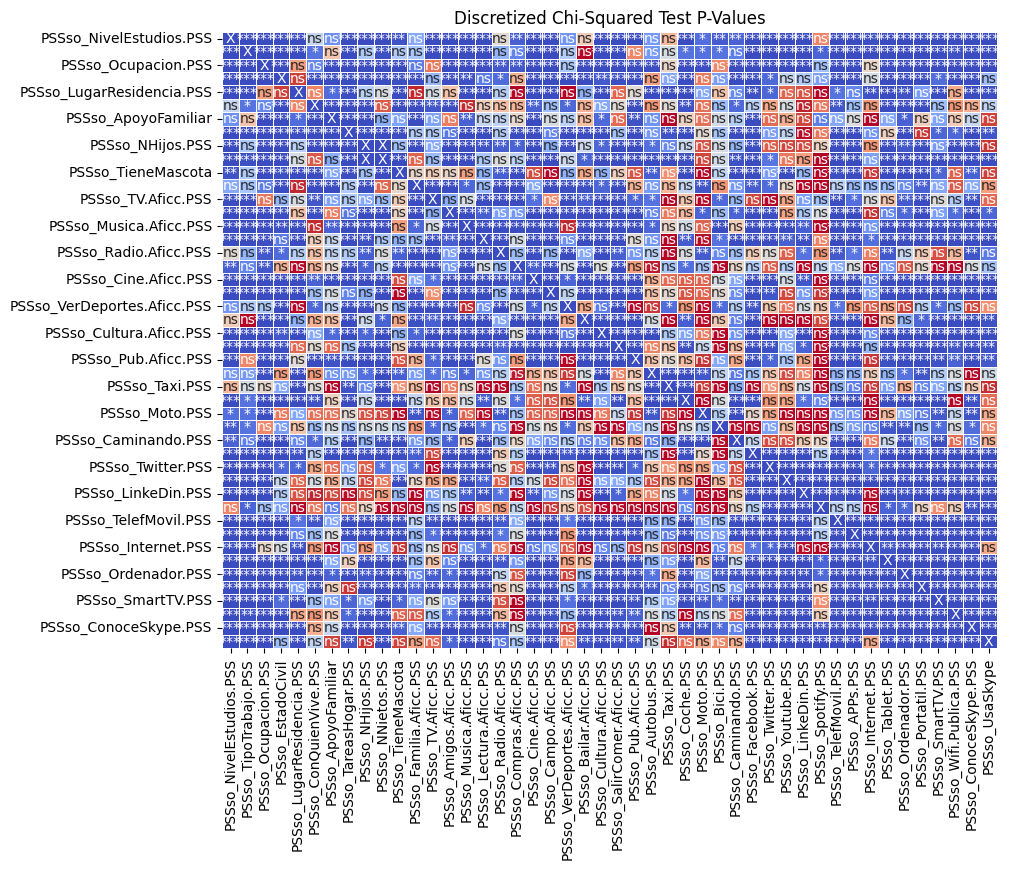

(                             ID  PSSso_NivelEstudios.PSS  \
 ID                          NaN                      NaN   
 PSSso_NivelEstudios.PSS     NaN             0.000000e+00   
 PSSso_TipoTrabajo.PSS       NaN            6.917394e-139   
 PSSso_Ocupacion.PSS         NaN             2.404655e-25   
 PSSso_EstadoCivil           NaN             2.544721e-16   
 PSSso_LugarResidencia.PSS   NaN             1.995028e-07   
 PSSso_ConQuienVive.PSS      NaN             4.147586e-01   
 PSSso_ApoyoFamiliar         NaN             1.630178e-01   
 PSSso_TareasHogar.PSS       NaN             1.458700e-08   
 PSSso_NHijos.PSS            NaN             2.816701e-11   
 PSSso_NNietos.PSS           NaN             3.078969e-25   
 PSSso_TieneMascota          NaN             1.629340e-02   
 PSSso_Familia.Aficc.PSS     NaN             2.308847e-01   
 PSSso_TV.Aficc.PSS          NaN             2.650572e-08   
 PSSso_Amigos.Aficc.PSS      NaN             3.768250e-06   
 PSSso_Musica.Aficc.PSS 

In [167]:
# We analyze the correlation between the variables
analyze_correlations(df_pss_soc_nonulls, ignore_vars=['ID', 'MuerteCV', 'Revasc'])